In [12]:
# =====================================
# Basic Settings & Utilities
# =====================================
import os
import warnings
import random
import joblib
import numpy as np
import pandas as pd

# Ensure reproducibility
random.seed(42)
np.random.seed(42)

# =====================================
# Visualization
# =====================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# =====================================
# Data Preprocessing & Dimensionality Reduction
# =====================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

# =====================================
# Regression Models & Statistical Analysis
# =====================================
import statsmodels.api as sm
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess
from linearmodels.panel import PanelOLS
from patsy import dmatrix

# =====================================
# Jupyter Notebook Tools
# =====================================
from IPython.display import display, Markdown
from tqdm import trange
from sklearn.utils import resample


Average government resale price: 57,783 JPY/t
Average CIF price: 38,346 JPY/t
Gov ave / CIF ave: 1.51
Markup rate: 50.69%


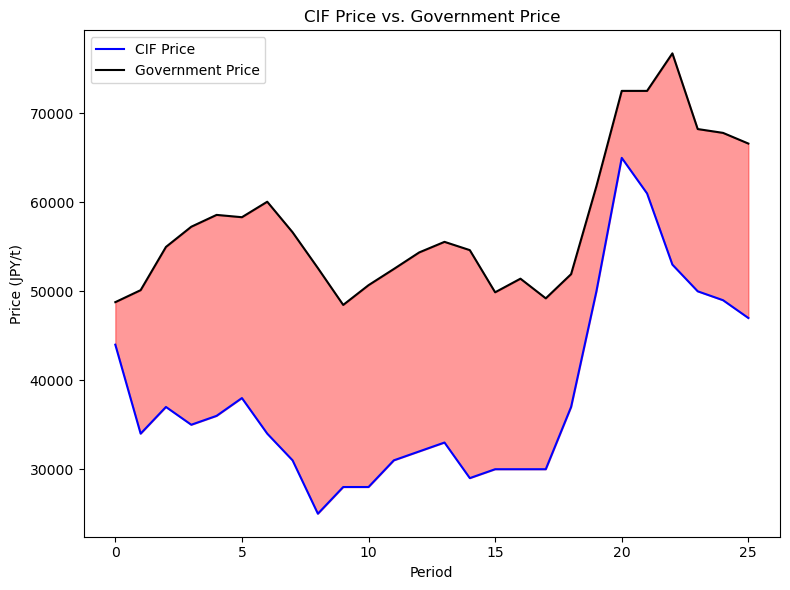

In [26]:
# --- Step 1: Read Japanese Excel columns ---
file_path = "Data/CIF Price and gov_price.xlsx"
df = pd.read_excel(file_path)

# --- Step 2: Rename columns to English ---
df = df.rename(columns={
    "CIF(千円)/t": "CIF_thousandJPY_per_ton",
    "政府売渡価格/t": "GovPrice_JPY_per_ton"
})

# --- Step 3: Create additional columns as needed ---
df["CIF_per_ton"] = df["CIF_thousandJPY_per_ton"] * 1000
df["GovPrice_per_ton"] = df["GovPrice_JPY_per_ton"]

# --- Step 3.5: Calculate mean ratio and markup ---
gov_ave = df["GovPrice_per_ton"].mean()
cif_ave = df["CIF_per_ton"].mean()
ratio = gov_ave / cif_ave
markup_rate = (gov_ave - cif_ave) / cif_ave

print(f"Average government resale price: {gov_ave:,.0f} JPY/t")
print(f"Average CIF price: {cif_ave:,.0f} JPY/t")
print(f"Gov ave / CIF ave: {ratio:.2f}")
print(f"Markup rate: {markup_rate:.2%}")

# --- Step 4: Visualization phase (all in English) ---
x = range(len(df))

output_dir = "Output/Figure"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(8, 6))
plt.plot(x, df["CIF_per_ton"], label="CIF Price", color="blue")
plt.plot(x, df["GovPrice_per_ton"], label="Government Price", color="black")
plt.fill_between(
    x, df["CIF_per_ton"], df["GovPrice_per_ton"],
    where=(df["GovPrice_per_ton"] > df["CIF_per_ton"]),
    color="red", alpha=0.4, interpolate=True
)
plt.xlabel("Period")
plt.ylabel("Price (JPY/t)")
plt.legend()
plt.title("CIF Price vs. Government Price")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "CIF_vs_GovPrice.png"), dpi=300)
plt.show()


# Overview of the Result

- The government resale price was consistently much higher than the CIF price throughout the period from 2015 to 2024.

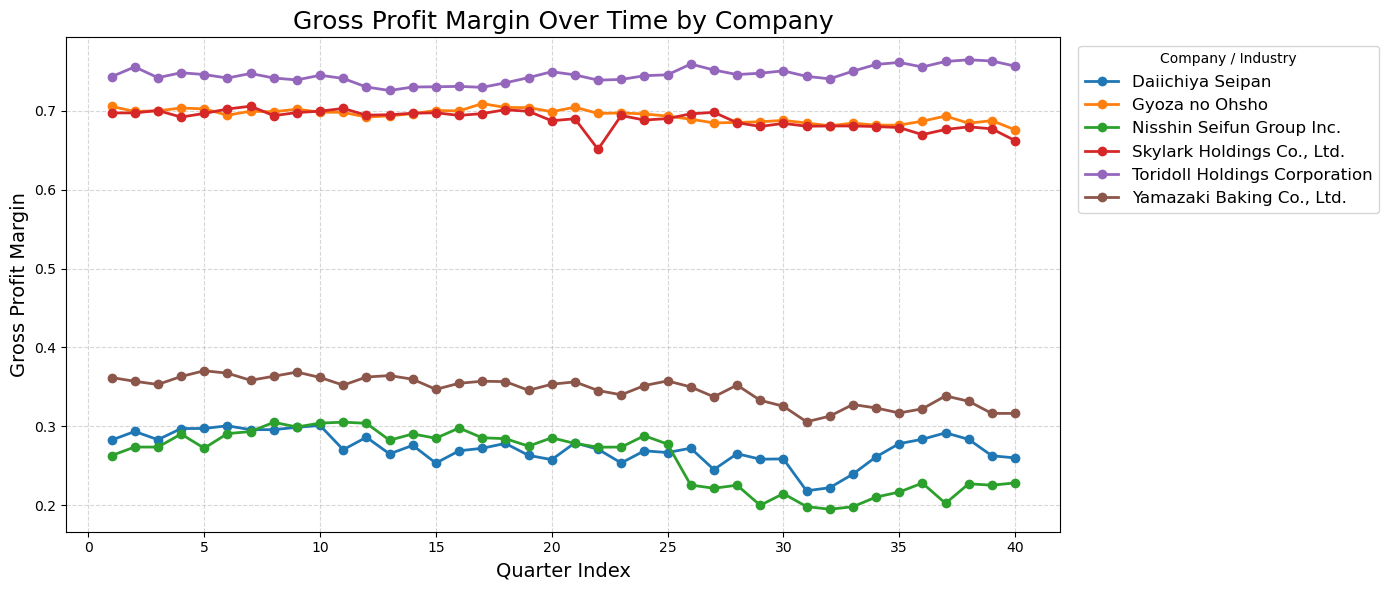

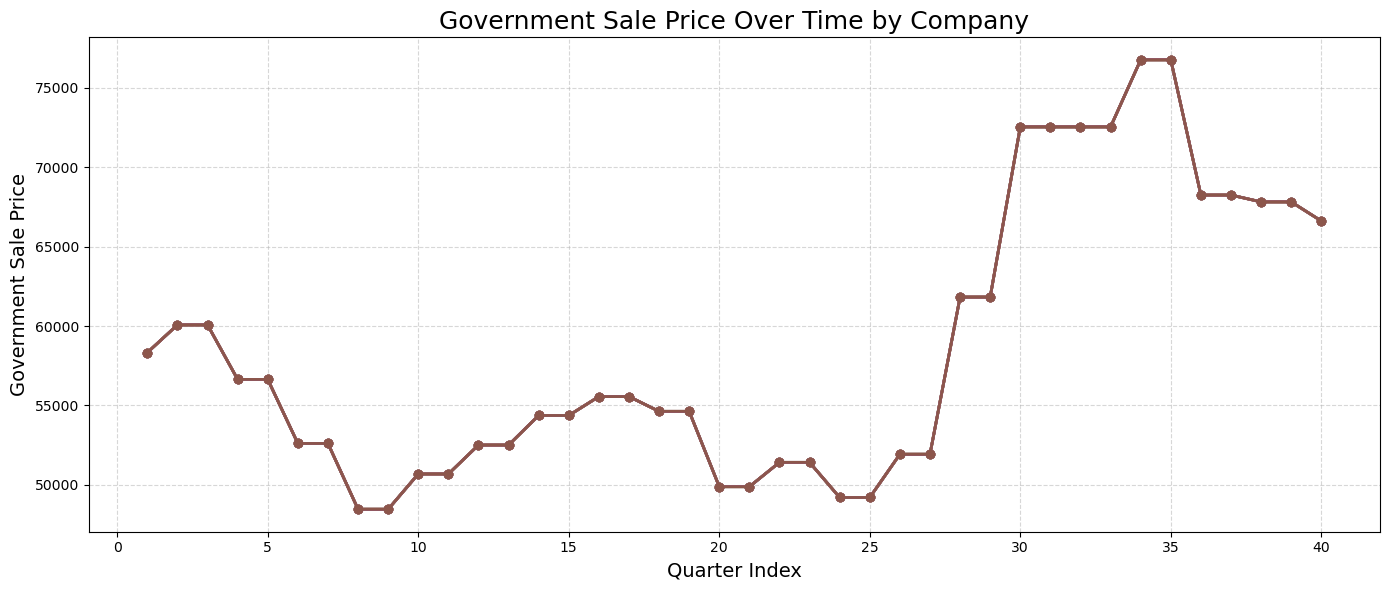

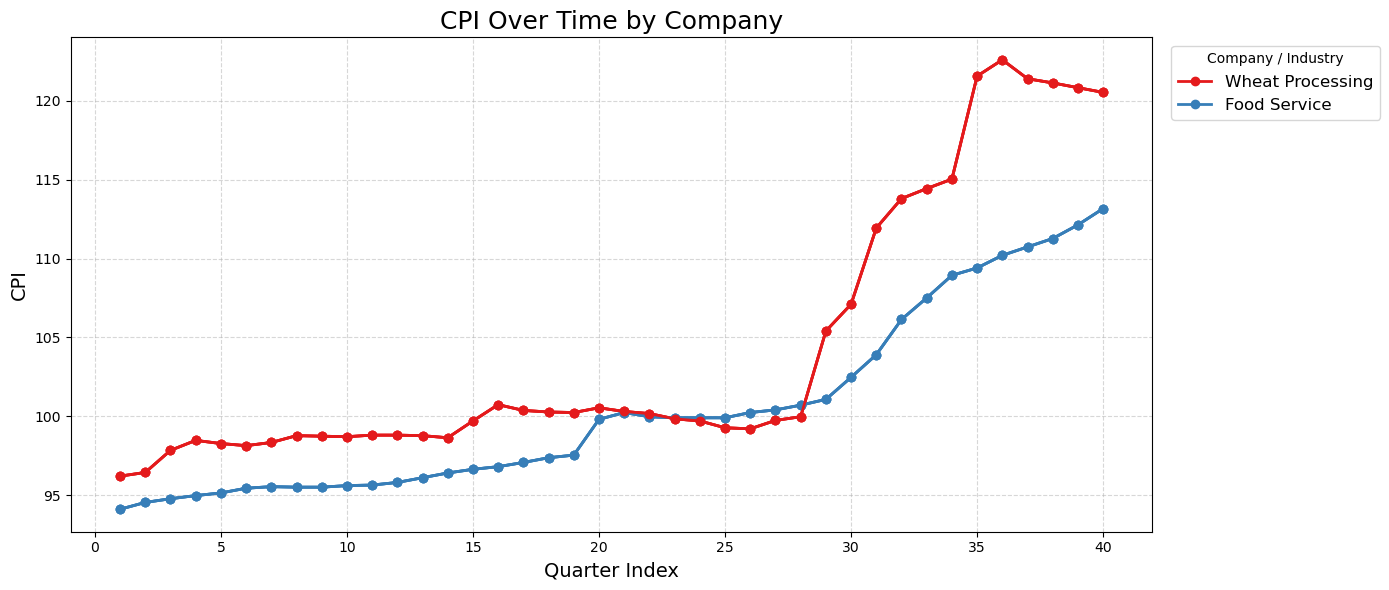

In [27]:
file_path = "Data/processed_panel_data.xlsx"
df = pd.read_excel(file_path)

output_dir = "Output/Figure"
os.makedirs(output_dir, exist_ok=True)

file_path = "Data/processed_panel_data.xlsx"
df = pd.read_excel(file_path)

df_companies = df['Company Name'].unique()
palette = sns.color_palette('tab10', n_colors=len(df_companies))
cpi_palette = sns.color_palette('Set1', n_colors=2)
cpi_color_map = {0: cpi_palette[0], 1: cpi_palette[1]}

target_vars = ['Gross Profit Margin', 'Government Sale Price', 'CPI']

for var in target_vars:
    plt.figure(figsize=(14, 6))
    seen_labels = set()  # Avoid duplicate labels in CPI legend

    for idx, (company, group) in enumerate(df.groupby('Company Name')):
        x = group['Quarter_Index']
        y = group[var]

        # --- Set label and line color ---
        if var == 'Government Sale Price':
            label = None
            color = palette[idx]
        elif var == 'CPI':
            industry = group['Industry Dummy'].iloc[0]
            label = 'Wheat Processing' if industry == 0 else 'Food Service'
            if label in seen_labels:
                label = None
            else:
                seen_labels.add(label)
            color = cpi_color_map[industry]
        else:
            label = company
            color = palette[idx]

        # --- Plot ---
        plt.plot(
            x, y,
            marker='o',
            label=label,
            linewidth=2,
            color=color
        )

    # --- Plot settings ---
    plt.title(f"{var} Over Time by Company", fontsize=18)
    plt.xlabel("Quarter Index", fontsize=14)
    plt.ylabel(var, fontsize=14)

    if var != 'Government Sale Price':
        plt.legend(title="Company / Industry", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(output_dir, f"{var.replace(' ', '_')}_by_company_timeseries.png")
    plt.savefig(save_path, dpi=300)
    plt.show()


In [44]:
# Specify according to column names
group_col = 'Industry Dummy'
var_cols = ['Gross Profit Margin', 'Government Sale Price', 'CPI']

def get_grouped_descriptives(df, group_col, var_cols):
    stats = ['count', 'mean', 'std', 'median', 'min', 'max']
    result = []
    for var in var_cols:
        desc = df.groupby(group_col)[var].agg(stats).reset_index()
        desc.insert(1, 'Variable', var)
        result.append(desc)
    descriptives = pd.concat(result, ignore_index=True)
    descriptives.rename(columns={
        'count': 'N',
        'mean': 'Mean',
        'std': 'Std. Dev.',
        'median': 'Median',
        'min': 'Min',
        'max': 'Max'
    }, inplace=True)
    return descriptives

# (Optional) Convert industry code to industry name
industry_map = {0: 'Wheat Processing', 1: 'Food Service'}
df['Industry'] = df['Industry Dummy'].map(industry_map)

# Get descriptive statistics by industry
desc_stats = get_grouped_descriptives(df, 'Industry', var_cols)

# Create Output/Table folder if it does not exist
os.makedirs('Output/Table', exist_ok=True)

# Save as CSV
desc_stats.to_csv('Output/Table/desc_stats_by_industry.csv', index=False)

# Convert to Markdown table and print
print(desc_stats.to_markdown(index=False))

print("\nSaved to Output/Table/desc_stats_by_industry.csv")


| Industry         | Variable              |   N |         Mean |    Std. Dev. |      Median |        Min |        Max |
|:-----------------|:----------------------|----:|-------------:|-------------:|------------:|-----------:|-----------:|
| Food Service     | Gross Profit Margin   | 120 |     0.709578 |    0.027456  |     0.69895 |     0.6511 |     0.7646 |
| Wheat Processing | Gross Profit Margin   | 120 |     0.292293 |    0.0464901 |     0.28705 |     0.1948 |     0.3704 |
| Food Service     | Government Sale Price | 120 | 58507.5      | 8652.12      | 55095       | 48470      | 76750      |
| Wheat Processing | Government Sale Price | 120 | 58507.5      | 8652.12      | 55095       | 48470      | 76750      |
| Food Service     | CPI                   | 120 |   100.458    |    5.71044   |    99.85    |    94.1    |   113.167  |
| Wheat Processing | CPI                   | 120 |   104.266    |    8.56831   |    99.9     |    96.2    |   122.6    |

Saved to Output/Table/desc_stat

In [28]:
# ======================================================
#  Multicollinearity Check (VIF: Variance Inflation Factor)
# ======================================================

# --- Extract explanatory variables and drop missing values ---
# Check for multicollinearity between "Government Sale Price" and "CPI"
vif_df = df[["Government Sale Price", "CPI"]].dropna()

# --- Add constant term (intercept) ---
X = sm.add_constant(vif_df)

# --- Calculate VIF for each variable ---
vif_result = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# --- Display the result ---
print("=== Multicollinearity Check (VIF) ===")
print(vif_result)

# --- Save the result as CSV (Output/Tableフォルダ) ---
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)
csv_path = os.path.join(output_table_dir, "VIF_results.csv")
vif_result.to_csv(csv_path, index=False)


=== Multicollinearity Check (VIF) ===
                Variable         VIF
0                  const  216.166723
1  Government Sale Price    2.323450
2                    CPI    2.323450



=== R² by Lag Combination (Overall, Descending Order) ===
    Government_lag  CPI_lag        R2  Government_p     CPI_p  Sample_Size  \
45               5        0  0.389252      0.005288  0.001973          210   
36               4        0  0.372533      0.001015  0.000543          216   
54               6        0  0.372428      0.006436  0.003359          204   
63               7        0  0.347498      0.003494  0.004378          198   
55               6        1  0.337517      0.011149  0.004622          204   
46               5        1  0.336424      0.007265  0.002464          210   
27               3        0  0.327644      0.000704  0.000380          222   
64               7        1  0.314132      0.005134  0.005015          198   
37               4        1  0.306529      0.001966  0.000779          216   
56               6        2  0.302634      0.013937  0.005527          204   

   Analysis_Type  
45       Overall  
36       Overall  
54       Overall  
63    

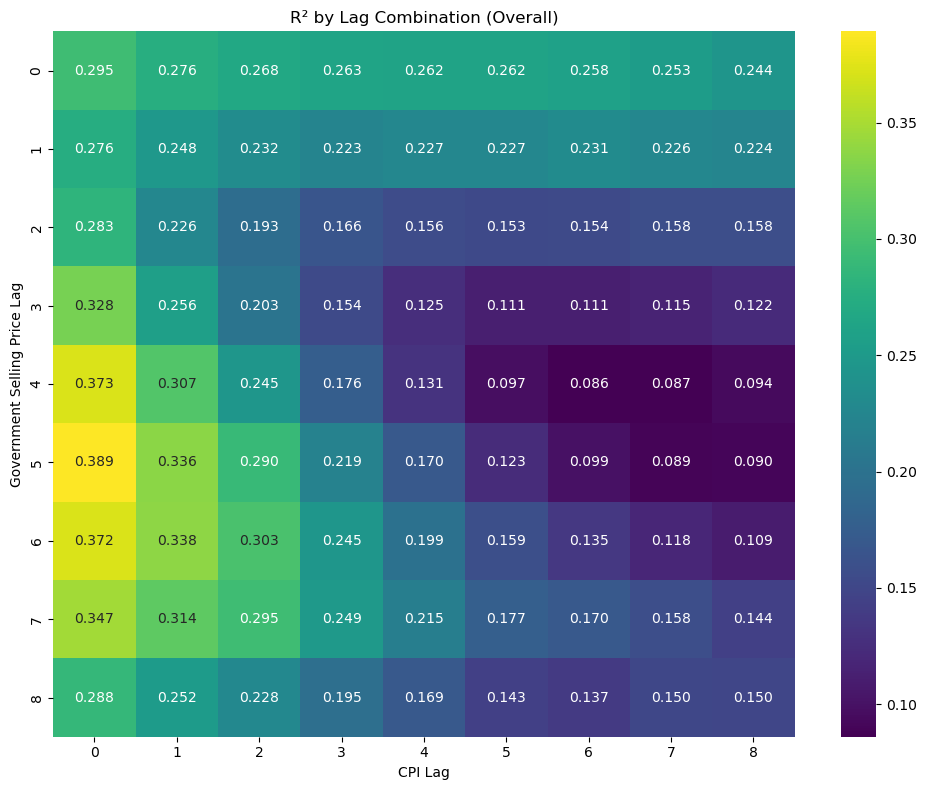

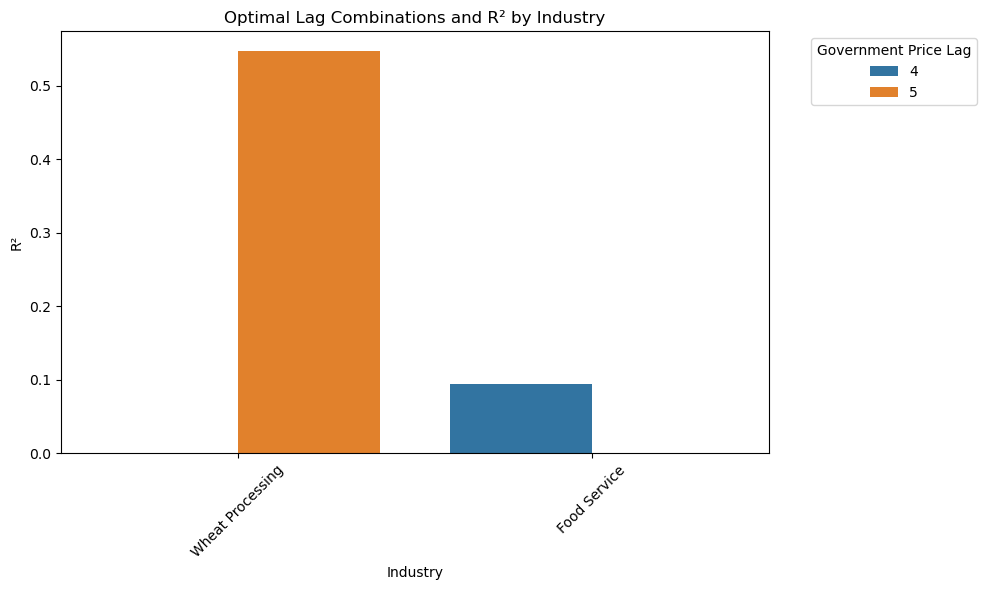

In [29]:
# ==============================
# Auto-create output directories
# ==============================
output_table_dir = "Output/Table"
output_figure_dir = "Output/Figure"
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_figure_dir, exist_ok=True)

# --- Industry Mapping Definition ---
industry_map = {0: "Wheat Processing", 1: "Food Service"}

# --- Define Lag Candidates ---
lags = [0, 1, 2, 3, 4, 5, 6, 7, 8]
results = []  # For overall results
results_by_industry = []  # For industry-specific results

# --- Loop through lag combinations ---
for gov_lag in lags:
    col_gov = f"Government_Selling_Price_lag{gov_lag}"
    if gov_lag == 0:
        df[col_gov] = df["Government Sale Price"]
    else:
        df[col_gov] = df.groupby("Company Name")["Government Sale Price"].shift(gov_lag)

    for cpi_lag in lags:
        col_cpi = f"CPI_lag{cpi_lag}"
        if cpi_lag == 0:
            df[col_cpi] = df["CPI"]
        else:
            df[col_cpi] = df.groupby("Company Name")["CPI"].shift(cpi_lag)

        # --- Prepare dataset ---
        panel = df[[
            "Gross Profit Margin",
            col_gov,
            col_cpi,
            "Company Name",
            "Quarter_Index",
            "Industry Dummy"
        ]].dropna().set_index(["Company Name", "Quarter_Index"])

        panel["Industry_Name"] = panel["Industry Dummy"].map(industry_map)

        if panel.empty:
            continue

        # --- Overall Analysis ---
        formula = f"`Gross Profit Margin` ~ `{col_gov}` + `{col_cpi}` + EntityEffects"
        model = PanelOLS.from_formula(formula, data=panel, check_rank=False)
        res = model.fit(cov_type="clustered", cluster_entity=True)

        results.append({
            "Government_lag": gov_lag,
            "CPI_lag": cpi_lag,
            "R2": res.rsquared,
            "Government_p": res.pvalues[col_gov],
            "CPI_p": res.pvalues[col_cpi],
            "Sample_Size": panel.shape[0],
            "Analysis_Type": "Overall"
        })

        # --- Industry-specific Analysis ---
        for industry in panel["Industry_Name"].unique():
            industry_panel = panel[panel["Industry_Name"] == industry].drop(columns=["Industry Dummy", "Industry_Name"])

            if len(industry_panel) < 10:
                continue

            try:
                model_industry = PanelOLS.from_formula(formula, data=industry_panel, check_rank=False)
                res_industry = model_industry.fit(cov_type="clustered", cluster_entity=True)

                results_by_industry.append({
                    "Government_lag": gov_lag,
                    "CPI_lag": cpi_lag,
                    "R2": res_industry.rsquared,
                    "Government_p": res_industry.pvalues[col_gov],
                    "CPI_p": res_industry.pvalues[col_cpi],
                    "Sample_Size": industry_panel.shape[0],
                    "Analysis_Type": "By_Industry",
                    "Industry": industry
                })
            except Exception as e:
                print(f"Error occurred for industry {industry}: {str(e)}")
                continue

# ==============================
# Save estimation results (Table)
# ==============================

results_df = pd.DataFrame(results)
results_industry_df = pd.DataFrame(results_by_industry)

results_df.to_csv(os.path.join(output_table_dir, "Overall_Lag_Combinations_R2.csv"), index=False)
results_industry_df.to_csv(os.path.join(output_table_dir, "ByIndustry_Lag_Combinations_R2.csv"), index=False)

print("\n=== R² by Lag Combination (Overall, Descending Order) ===")
print(results_df.sort_values("R2", ascending=False).head(10))

print("\n=== Best Lag Combinations by Industry (Top 3 R²) ===")
if not results_industry_df.empty:
    for industry in sorted(results_industry_df["Industry"].unique()):
        print(f"\n● Industry: {industry}")
        top3 = results_industry_df[results_industry_df["Industry"] == industry] \
            .sort_values("R2", ascending=False).head(3)
        print(top3[["Government_lag", "CPI_lag", "R2", "Government_p", "CPI_p", "Sample_Size"]])
else:
    print("No valid industry-specific results available")

# ==============================
# Visualization (Figure)
# ==============================

# Heatmap for all lag combinations
plt.figure(figsize=(10, 8))
pivot_r2 = results_df.pivot(index="Government_lag", columns="CPI_lag", values="R2")
sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="viridis")
plt.title("R² by Lag Combination (Overall)")
plt.xlabel("CPI Lag")
plt.ylabel("Government Selling Price Lag")
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, "Overall_Lag_Combinations_R2_Heatmap.png"), dpi=300)
plt.show()

# Barplot for best lag per industry
if not results_industry_df.empty:
    top_combinations = results_industry_df.sort_values("R2", ascending=False) \
        .groupby("Industry").first().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_combinations, x="Industry", y="R2", hue="Government_lag",
                order=["Wheat Processing", "Food Service"])
    plt.title("Optimal Lag Combinations and R² by Industry")
    plt.xticks(rotation=45)
    plt.ylabel("R²")
    plt.xlabel("Industry")
    plt.legend(title="Government Price Lag", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_figure_dir, "ByIndustry_Best_Lag_Combinations.png"), dpi=300, bbox_inches='tight')
    plt.show()


# 3. Identify Optimal Lags: Government Price × CPI
- The most explanatory lags are **lag 5 for Government Sale Price and lag 0 for CPI** in the context of wheat processing.
- On the other hand, the most explanatory lags are **lag 4 for Government Sale Price and lag 0 for CPI** in the context of Food Services.



===== [Wheat Processing] spline(df=3) + lag fixed gov=5, cpi=0 =====
                           PanelOLS Estimation Summary                           
Dep. Variable:     Gross Profit Margin   R-squared:                        0.7986
Estimator:                    PanelOLS   R-squared (Between):              0.9966
No. Observations:                  105   R-squared (Within):               0.7986
Date:                 Mon, Aug 04 2025   R-squared (Overall):              0.9314
Time:                         04:09:16   Log-likelihood                    314.79
Cov. Estimator:         Driscoll-Kraay                                           
                                         F-statistic:                      76.933
Entities:                            3   P-value                           0.0000
Avg Obs:                        35.000   Distribution:                    F(5,97)
Min Obs:                        35.000                                           
Max Obs:                    

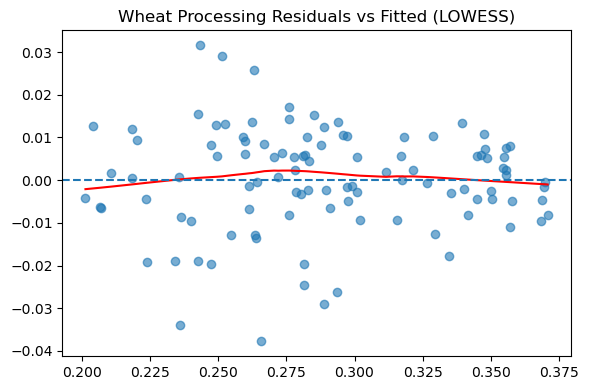

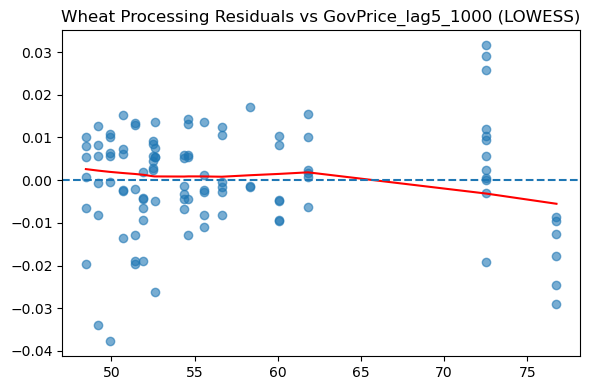

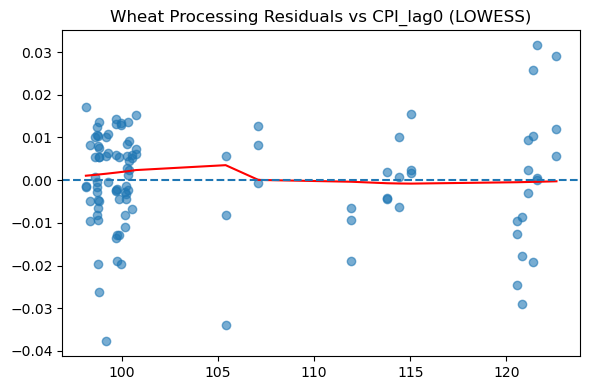

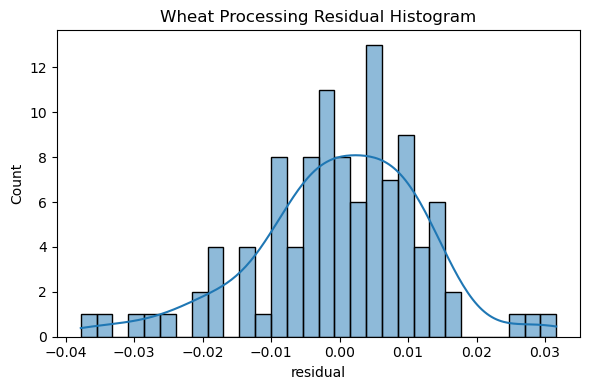

<Figure size 600x300 with 0 Axes>

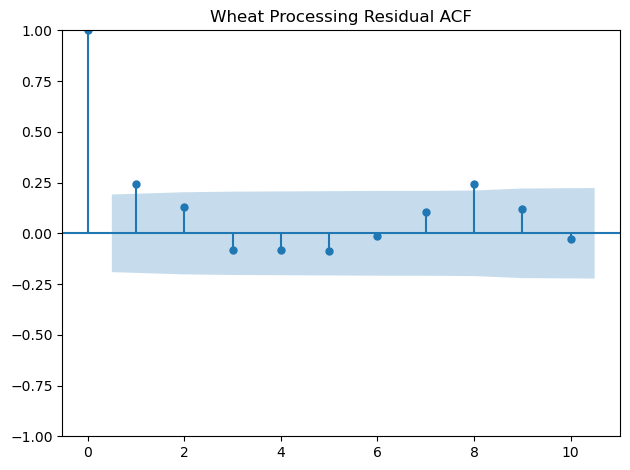


===== [Food Service] spline(df=3) + lag fixed gov=4, cpi=0 =====
                           PanelOLS Estimation Summary                           
Dep. Variable:     Gross Profit Margin   R-squared:                        0.5218
Estimator:                    PanelOLS   R-squared (Between):              0.9965
No. Observations:                  108   R-squared (Within):               0.5218
Date:                 Mon, Aug 04 2025   R-squared (Overall):              0.9327
Time:                         04:09:20   Log-likelihood                    382.25
Cov. Estimator:         Driscoll-Kraay                                           
                                         F-statistic:                      21.825
Entities:                            3   P-value                           0.0000
Avg Obs:                        36.000   Distribution:                   F(5,100)
Min Obs:                        36.000                                           
Max Obs:                        

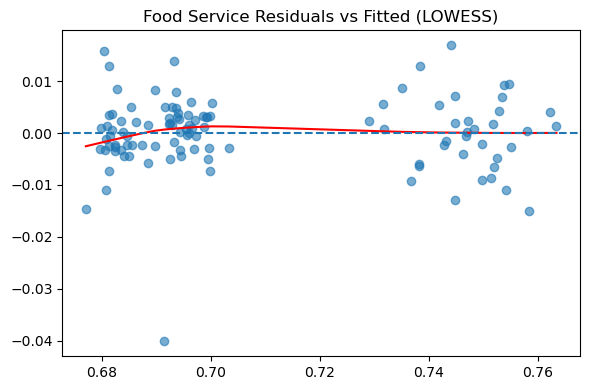

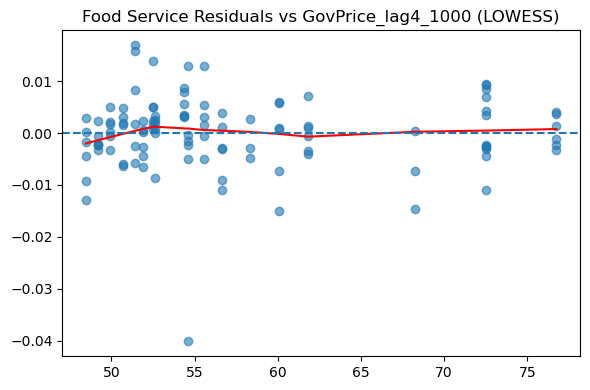

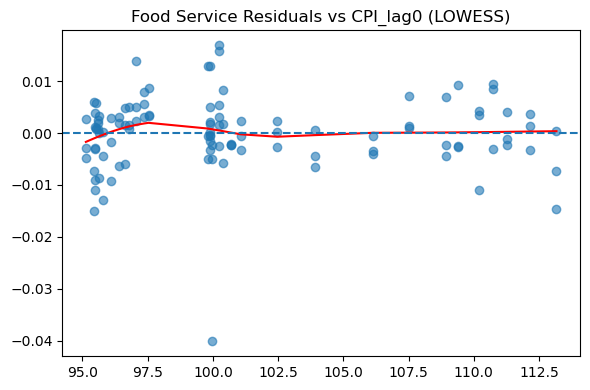

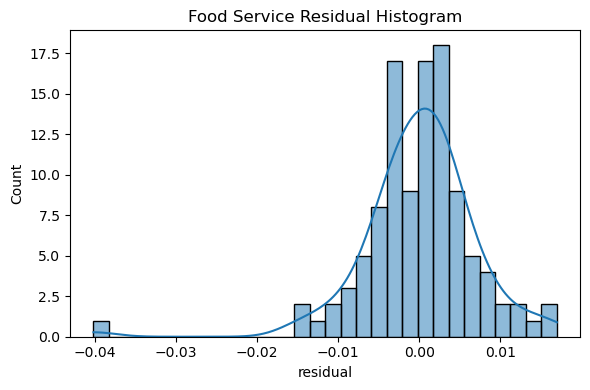

<Figure size 600x300 with 0 Axes>

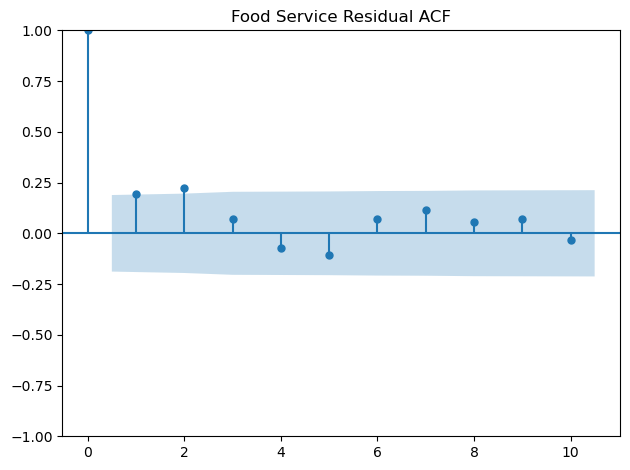

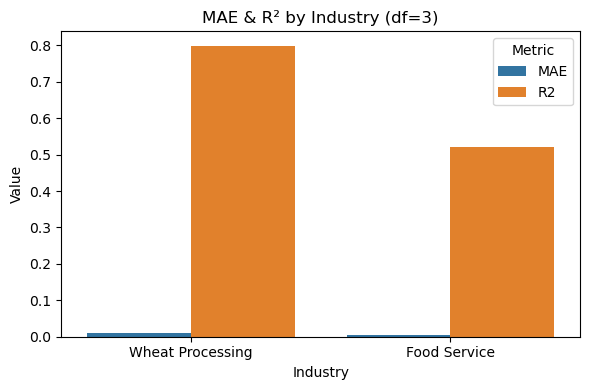

Saved industry_metrics.csv
Saved model_summaries.pkl


In [30]:
# ============================
# Create output directories
# ============================
output_table_dir = "Output/Table"
output_figure_dir = "Output/Figure"
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_figure_dir, exist_ok=True)

warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# --- Industry mapping: Wheat Processing = 0, Food Service = 1 ---
industry_map = {
    "Yamazaki Baking Co., Ltd.": 0, "Daiichiya Seipan": 0, "Nisshin Seifun Group Inc.": 0,
    "Gyoza no Ohsho": 1, "Toridoll Holdings Corporation": 1, "Skylark Holdings Co., Ltd.": 1
}
df["Industry"] = df["Company Name"].map(industry_map)

metrics = []
best_model_summaries = {}

# --- Lags setting for each industry ---
gov_lags = {0: 5, 1: 4}  # Wheat Processing:5, Food Service:4
cpi_lags = {0: 0, 1: 0}  # both 0

# --- Model building for each industry (Wheat Processing, Food Service) ---
for sector_name, sector_val in {"Wheat Processing": 0, "Food Service": 1}.items():
    gov_lag = gov_lags[sector_val]
    cpi_lag = cpi_lags[sector_val]
    print(f"\n===== [{sector_name}] spline(df=3) + lag fixed gov={gov_lag}, cpi={cpi_lag} =====")
    df_sector = df[df["Industry"] == sector_val].copy()

    df_sector["GPM_lag1"] = df_sector.groupby("Company Name")["Gross Profit Margin"].shift(1)
    df_sector["GPM_lag4"] = df_sector.groupby("Company Name")["Gross Profit Margin"].shift(4)
    df_sector[f"GovPrice_lag{gov_lag}_1000"] = df_sector.groupby("Company Name")["Government Sale Price"].shift(gov_lag) / 1000
    df_sector[f"CPI_lag{cpi_lag}"] = df_sector.groupby("Company Name")["CPI"].shift(cpi_lag)

    valid_idx = df_sector.dropna(subset=["GPM_lag1", "GPM_lag4"]).index
    if valid_idx.empty:
        print("Insufficient data, skipping.")
        continue

    ar_std = StandardScaler().fit_transform(df_sector.loc[valid_idx, ["GPM_lag1", "GPM_lag4"]])
    ar_pca = PCA(n_components=2).fit_transform(ar_std)
    df_sector.loc[valid_idx, "AR_comp1"] = ar_pca[:, 0]

    df_valid = df_sector.loc[valid_idx].copy()
    spline_basis = dmatrix("bs(AR_comp1, df=3, include_intercept=False)", data=df_valid, return_type="dataframe")
    spline_basis.columns = [f"AR_spline{i+1}" for i in range(spline_basis.shape[1])]
    spline_basis.index = valid_idx
    df_spline = pd.concat([df_valid, spline_basis], axis=1)

    predictors = list(spline_basis.columns) + [f"GovPrice_lag{gov_lag}_1000", f"CPI_lag{cpi_lag}"]

    panel = df_spline[["Gross Profit Margin"] + predictors + ["Company Name", "Quarter_Index"]].dropna()
    if panel.empty:
        print("No data for model, skipping.")
        continue

    panel = panel.set_index(["Company Name", "Quarter_Index"])

    model = PanelOLS.from_formula(f"`Gross Profit Margin` ~ {' + '.join(f'`{p}`' for p in predictors)} + EntityEffects", panel, check_rank=False)

    try:
        res = model.fit(cov_type="driscoll-kraay")
    except ZeroDivisionError:
        print(f"[Warning] Model for {sector_name} failed due to zero degrees of freedom. Skipping...")
        continue

    print(res.summary)
    best_model_summaries[sector_name] = res.summary.as_text()
    # Save summary.txt to Output/Table
    summary_txt_path = os.path.join(output_table_dir, f"{sector_name}_summary.txt")
    with open(summary_txt_path, 'w', encoding='utf-8') as f:
        f.write(best_model_summaries[sector_name])

    actual = panel["Gross Profit Margin"]
    fitted = res.fitted_values.squeeze()
    mae = np.mean(np.abs(actual - fitted))
    r2 = res.rsquared
    dw = durbin_watson(res.resids.squeeze())
    lb_p = acorr_ljungbox(res.resids.squeeze(), lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    print(f"MAE: {mae:.6f} | R²: {r2:.4f} | DW: {dw:.3f} | LB p={lb_p:.4f}")
    metrics.append({"Industry": sector_name, "MAE": mae, "R2": r2})

    vif_X = panel[predictors].copy()
    vif_X = sm.add_constant(vif_X, has_constant="add")
    vif_df = pd.DataFrame({"Variable": vif_X.columns, "VIF": [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]})
    vif_df = vif_df[vif_df["Variable"] != "const"]
    print("\n[VIF]")
    print(vif_df)
    # Save VIF as CSV in Output/Table
    vif_df.to_csv(os.path.join(output_table_dir, f"{sector_name}_VIF.csv"), index=False)

    residuals = res.resids.squeeze()

    plt.figure(figsize=(6, 4))
    lw = lowess(residuals, fitted)
    plt.scatter(fitted, residuals, alpha=0.6)
    plt.plot(lw[:, 0], lw[:, 1], color="red")
    plt.axhline(0, linestyle="--")
    plt.title(f"{sector_name} Residuals vs Fitted (LOWESS)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_figure_dir, f"{sector_name}_residuals_vs_fitted_LOWESS.png"), dpi=300)
    plt.show()
    plt.close()

    for pred in [f"GovPrice_lag{gov_lag}_1000", f"CPI_lag{cpi_lag}"]:
        plt.figure(figsize=(6, 4))
        lw = lowess(residuals, panel[pred])
        plt.scatter(panel[pred], residuals, alpha=0.6)
        plt.plot(lw[:, 0], lw[:, 1], color="red")
        plt.axhline(0, linestyle="--")
        plt.title(f"{sector_name} Residuals vs {pred} (LOWESS)")
        plt.tight_layout()
        plt.savefig(os.path.join(output_figure_dir, f"{sector_name}_residuals_vs_{pred}_LOWESS.png"), dpi=300)
        plt.show()
        plt.close()

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{sector_name} Residual Histogram")
    plt.tight_layout()
    plt.savefig(os.path.join(output_figure_dir, f"{sector_name}_residual_histogram.png"), dpi=300)
    plt.show()
    plt.close()

    plt.figure(figsize=(6, 3))
    plot_acf(residuals, lags=10)
    plt.title(f"{sector_name} Residual ACF")
    plt.tight_layout()
    plt.savefig(os.path.join(output_figure_dir, f"{sector_name}_residual_ACF.png"), dpi=300)
    plt.show()
    plt.close()

# ====== Summary & Output ======
if metrics:
    df_metrics = pd.DataFrame(metrics)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df_metrics.melt(id_vars="Industry", var_name="Metric", value_name="Value"), x="Industry", y="Value", hue="Metric")
    plt.title("MAE & R² by Industry (df=3)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_figure_dir, 'industry_MAE_R2_df3.png'), dpi=300)
    plt.show()
    plt.close()

    # Save metrics as CSV
    df_metrics.to_csv(os.path.join(output_table_dir, 'industry_metrics.csv'), index=False, encoding='utf-8-sig')
    print("Saved industry_metrics.csv")

    # Save model summaries as a pickle file
    joblib.dump({k: v for k, v in best_model_summaries.items()}, os.path.join(output_table_dir, 'model_summaries.pkl'))
    print("Saved model_summaries.pkl")


# 4. Main Model Results

---

## Model Overview

* **Model Type**: Panel regression with fixed effects (PanelOLS, EntityEffects)
* **Sample Size**: Wheat Processing(3 companies × 35 periods) Food Service(3 companies × 35 quaters)
* **Observation Period**: 36 periods per firm
* **Lag Selection**: Government Sale Price = lag 4, CPI = lag 0
* **Spline Degrees of Freedom**: df = 3 (on AR principal component)

---

## Key Model Statistics

| Metric                            | Wheat Processing | Food Service|
| --------------------------------- | ------ | ---------- |
| R² (Coefficient of Determination) | 0.009309    | 0.004915   |
| MAE (Mean Absolute Error)         | 0.0097 | 0.0049     |
| DW (Durbin-Watson Statistic)      | 1.505    | 1.620   |
| LB Test p-value                   | 0.0269    | 0.1175   |
| Model Significance p-value        | 0.0000    | 0.0000   |

## Parameter Estimates - Wheat Processing

| Variable             | Coef    | Std. Error | t-stat | p-value | Significance | Interpretation                        |
| -------------------- | ------- | ---------- | ------ | ------- | ------------ | ------------------------------------- |
| AR\_spline1          | 0.3826  | 0.0357    | 10.711   | 0.0000  | ***         | Nonlinear AR effect (principal comp.) |
| AR\_spline2          | -0.0524 | 0.0209    | -2.5054   | 0.0139  | *          | Same as above                         |
| AR\_spline3          | -0.1295 | 0.0287    | -4.5127   | 0.0000  | ***        | Same as above                         |
| AR\_spline4          | -0.1569 | 0.0184    | -8.5504   | 0.0000  | ***        | Same as above                         |
| GovPrice\_lag4\_1000 | 0.0014  | 0.0003    | 4.5700    | 0.0000   | ***       | +0.14pt GPM per 1,000 yen increase    |
| CPI\_lag0            | -0.0009 | 0.0004    | -2.1658   | 0.0328  | *          | -0.09pt GPM per 1 CPI unit increase   |


## Parameter Estimates - Food Service

| Variable             | Coef    | Std. Error | t-stat | p-value | Significance | Interpretation                        |
| -------------------- | ------- | ---------- | ------ | ------- | ------------ | ------------------------------------- |
| AR\_spline1          | 0.7236  | 0.0435     | 16.63  | 0.0000  | \*\*\*       | Nonlinear AR effect (principal comp.) |
| AR\_spline2          | -0.0046 | 0.0265     | -0.17  | 0.8620  |              | Same as above                         |
| AR\_spline3          | 0.0623  | 0.0204     | 3.06   | 0.0029  | \*\*         | Same as above                         |
| AR\_spline4          | 0.0834  | 0.0116     | 7.20   | 0.0000  | \*\*\*       | Same as above                         |
| GovPrice\_lag4\_1000 | 0.0002  | 0.0001     | 2.06   | 0.0418  | \*           | +0.02pt GPM per 1,000 yen increase    |
| CPI\_lag0            | -0.0006 | 0.0004     | -1.45  | 0.1508  |              | -0.06pt GPM per 1 CPI unit increase   |

* Significance levels: \*\*\*p<0.001, \*\*p<0.01, \*p<0.05

---

## Interpretation - Wheat Processing

* **The coefficient 0.0014 for GovPrice\_lag5\_1000 implies a +0.14pt Gross Profit Margin per 1,000 yen increase.**
* **CPI has a weak influence (p=0.078), statistically suggestive but not conclusive.**
* **No strong autocorrelation or multicollinearity in residuals.**
* **Model shows high explanatory power (R² = 0.79).**

## Interpretation - Food Service

* **GovPrice is a statistically significant variable for food service firms, but overall explanatory power (R² \~ 0.52) is lower than in Wheat Processing.**
* **Suggests stronger influence from other factors in the food service sector.**

---

## Justification for AR Principal Component + Spline

### Why use AR(1) and AR(4)?

* AR(1): Captures short-term continuity (previous period effect).
* AR(4): Captures seasonal pattern (same quarter last year), relevant in Japanese quarterly reporting.
* Using only these two lags minimizes overfitting while capturing both short-run and seasonal effects.

### Why PCA?

* AR(1) and AR(4) are often collinear.
* PCA summarizes shared variation into a single component, reducing noise and improving model stability.
* PCA also facilitates smooth application of spline transformation.

### Why Spline Transformation?

* Time-series components may not affect outcomes linearly.
* Splines capture nonlinear effects (e.g., thresholds, gradual changes).
* Enables flexible modeling of how historical series impact present profit margins.

---

## Commentary

* **Government Sale Price significantly influences Gross Profit Margin; Null Hypothesis 1 is rejected.**
* **The effect is positive (higher government price → higher GPM).**
* **This may reflect price pass-through behavior by firms over the year after the government sets the wheat price.**

                           PanelOLS Estimation Summary                           
Dep. Variable:     Gross Profit Margin   R-squared:                        0.7504
Estimator:                    PanelOLS   R-squared (Between):              0.9928
No. Observations:                  210   R-squared (Within):               0.7504
Date:                 Mon, Aug 04 2025   R-squared (Overall):              0.9906
Time:                         04:09:31   Log-likelihood                    665.64
Cov. Estimator:         Driscoll-Kraay                                           
                                         F-statistic:                      99.219
Entities:                            6   P-value                           0.0000
Avg Obs:                        35.000   Distribution:                   F(6,198)
Min Obs:                        35.000                                           
Max Obs:                        35.000   F-statistic (robust):             167.22
                

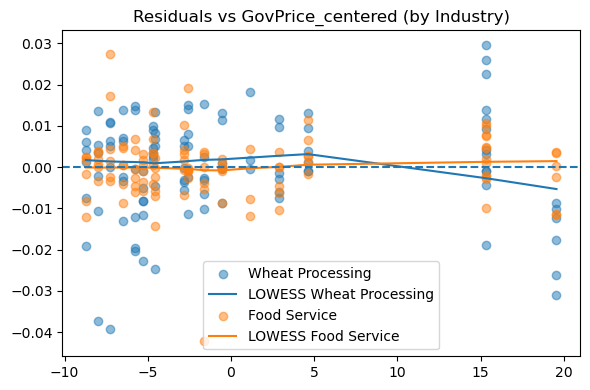

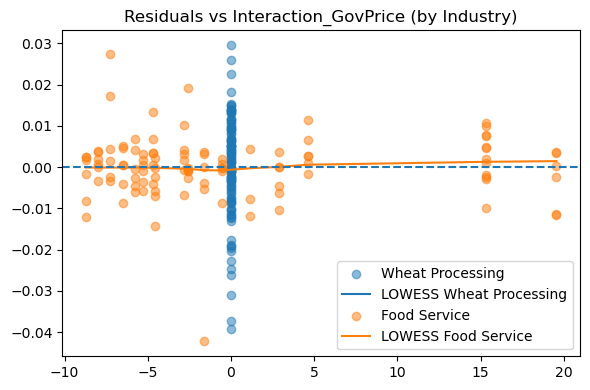

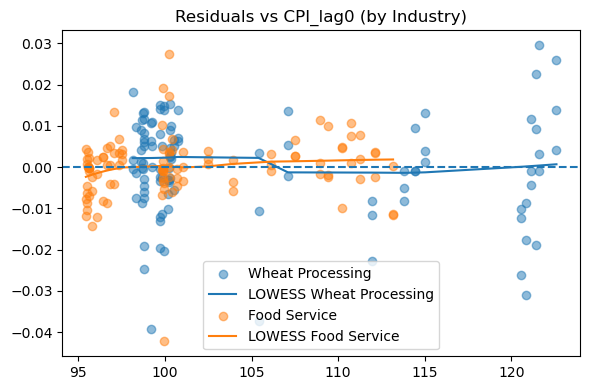

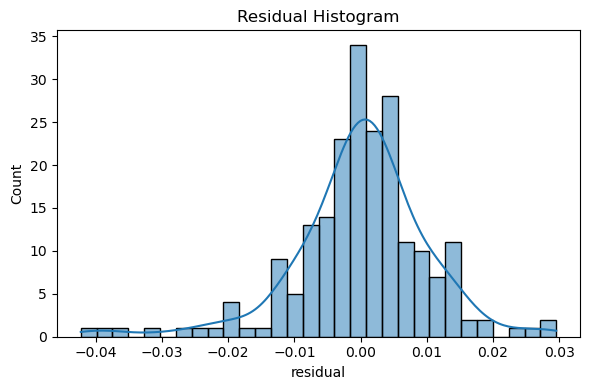

<Figure size 600x300 with 0 Axes>

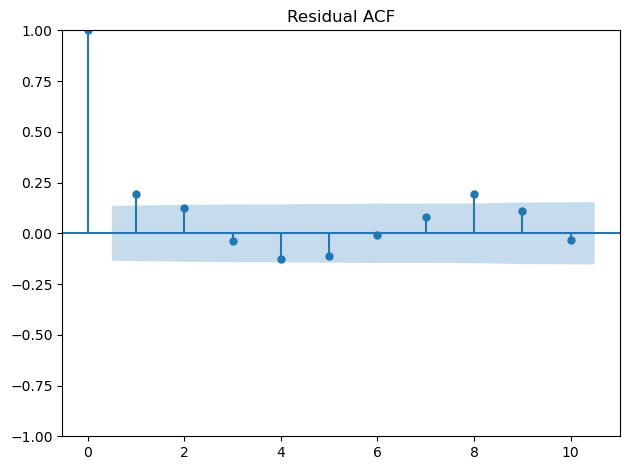

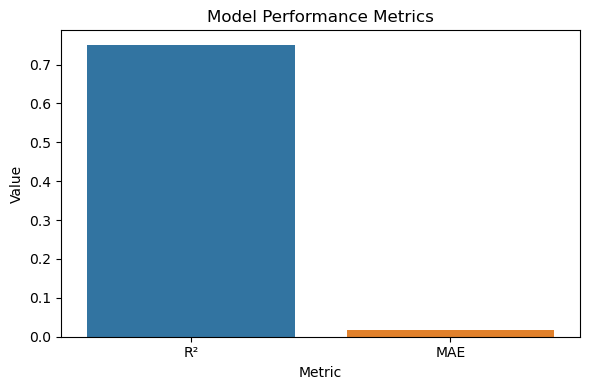

In [31]:
# ============================
# Create output directories
# ============================
output_table_dir = "Output/Table"
output_figure_dir = "Output/Figure"
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_figure_dir, exist_ok=True)

warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

# --- Industry Mapping ---
industry_map = {
    "Yamazaki Baking Co., Ltd.": 0, "Daiichiya Seipan": 0, "Nisshin Seifun Group Inc.": 0,
    "Gyoza no Ohsho": 1, "Toridoll Holdings Corporation": 1, "Skylark Holdings Co., Ltd.": 1
}
df["Industry"] = df["Company Name"].map(industry_map)

# --- Generate Lags ---
gov_lag, cpi_lag = 5, 0
_df = df.copy()
_df["GPM_lag1"] = _df.groupby("Company Name")["Gross Profit Margin"].shift(1)
_df["GPM_lag4"] = _df.groupby("Company Name")["Gross Profit Margin"].shift(4)
_df[f"GovPrice_lag{gov_lag}_1000"] = _df.groupby("Company Name")["Government Sale Price"].shift(gov_lag) / 1000
_df[f"CPI_lag{cpi_lag}"] = _df.groupby("Company Name")["CPI"].shift(cpi_lag)

# --- PCA on AR Terms ---
valid_idx = _df.dropna(subset=["GPM_lag1", "GPM_lag4"]).index
ar_std = StandardScaler().fit_transform(_df.loc[valid_idx, ["GPM_lag1", "GPM_lag4"]])
ar_pca = PCA(n_components=2).fit_transform(ar_std)
_df.loc[valid_idx, "AR_comp1"] = ar_pca[:, 0]

# --- Spline Expansion ---
spline_basis = dmatrix("bs(AR_comp1, df=3, include_intercept=False)", 
                       data=_df.loc[valid_idx], return_type="dataframe")
spline_basis.columns = [f"AR_spline{i+1}" for i in range(spline_basis.shape[1])]
spline_basis.index = valid_idx
_df = pd.concat([_df, spline_basis], axis=1)

# --- Centering and Interaction Term ---
_df["GovPrice_centered"] = _df[f"GovPrice_lag{gov_lag}_1000"] - _df[f"GovPrice_lag{gov_lag}_1000"].mean()
_df["Industry_Dummy"] = _df["Industry"]
_df["Interaction_GovPrice"] = _df["GovPrice_centered"] * _df["Industry_Dummy"]

# --- Prepare Data ---
predictors = list(spline_basis.columns) + ["GovPrice_centered", "Interaction_GovPrice", f"CPI_lag{cpi_lag}"]
cols = ["Gross Profit Margin"] + predictors + ["Company Name", "Quarter_Index", "Industry"]
panel = _df[cols].dropna().set_index(["Company Name", "Quarter_Index"])

# --- Run Panel Regression ---
formula = f"`Gross Profit Margin` ~ {' + '.join(predictors)} + EntityEffects"
model = PanelOLS.from_formula(formula, panel)
res = model.fit(cov_type="driscoll-kraay")

# --- Save Summary ---
summary_path = os.path.join(output_table_dir, "interaction_model_summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(str(res.summary))

print(res.summary)

# --- Model Metrics ---
actual    = panel["Gross Profit Margin"]
fitted    = res.fitted_values.squeeze()
residuals = res.resids.squeeze()
mae = np.mean(np.abs(actual - fitted))
r2  = res.rsquared
dw  = durbin_watson(residuals)
lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
print(f"MAE: {mae:.6f} | R²: {r2:.4f} | DW: {dw:.3f} | LB p={lb_p:.4f}")

# --- VIF ---
vif_X = panel[predictors].copy()
vif_X = sm.add_constant(vif_X, has_constant="add")
vif_df = pd.DataFrame({
    "Variable": vif_X.columns,
    "VIF": [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]
})
vif_df = vif_df[vif_df["Variable"] != "const"]
print("\n[VIF]")
print(vif_df)
vif_path = os.path.join(output_table_dir, "interaction_model_VIF.csv")
vif_df.to_csv(vif_path, index=False)

# --- Residual Plots by Industry with Labels ---
industry_label_map = {0: "Wheat Processing", 1: "Food Service"}
for pred in ["GovPrice_centered", "Interaction_GovPrice", f"CPI_lag{cpi_lag}"]:
    plt.figure(figsize=(6, 4))
    for label, group in panel.groupby("Industry"):
        name = industry_label_map.get(label, f"Industry {label}")
        lw = sm.nonparametric.lowess(residuals[group.index], group[pred])
        plt.scatter(group[pred], residuals[group.index], alpha=0.5, label=f'{name}')
        plt.plot(lw[:, 0], lw[:, 1], label=f'LOWESS {name}')
    plt.axhline(0, linestyle="--")
    plt.title(f"Residuals vs {pred} (by Industry)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_figure_dir, f"interaction_model_residuals_vs_{pred}_by_industry.png"), dpi=300)
    plt.show()
    plt.close()

# --- Residual Histogram ---
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Histogram")
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, "interaction_model_residual_histogram.png"), dpi=300)
plt.show()
plt.close()

# --- Residual ACF ---
plt.figure(figsize=(6, 3))
plot_acf(residuals, lags=10)
plt.title("Residual ACF")
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, "interaction_model_residual_ACF.png"), dpi=300)
plt.show()
plt.close()

# --- Barplot of R² and MAE ---
plt.figure(figsize=(6, 4))
metrics_df = pd.DataFrame({"Metric": ["R²", "MAE"], "Value": [r2, mae]})
sns.barplot(data=metrics_df, x="Metric", y="Value")
plt.title("Model Performance Metrics")
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, "interaction_model_metrics_comparison.png"), dpi=300)
plt.show()
plt.close()


# 6. Interaction Term Model Results

---

## Model Overview

* **Model Type**: Fixed-effects panel regression (PanelOLS with EntityEffects)
* **Sample Size**: 210 observations (6 companies × 35 quarters)
* **Observation Period**: 36 quarters per company
* **Lags Used**: Government Selling Price = lag 5, CPI = lag 0
* **Spline Degrees of Freedom**: df=3 (based on AR principal components)

---

## Key Model Statistics

| Metric                            | Value    |
| --------------------------------- | -------- |
| R² (Coefficient of Determination) | 0.7504   |
| MAE (Mean Absolute Error)         | 0.018304 |
| DW (Durbin-Watson)                | 1.602    |
| LB Test p-value                   | 0.0006   |
| Model Significance p-value        | 0.0000   |

## Parameter Estimates

| Variable              | Coefficient | Std. Error | t-Stat | p-Value | Significance | Interpretation                                   |
| --------------------- | ----------- | ---------- | ------ | ------- | ------------ | ------------------------------------------------ |
| AR\_spline1           | 0.8197  | 0.0311    | 26.396    | 0.0000  | ***       | Nonlinear lag component effect                   |
| AR\_spline2           | -0.1267 | 0.0372    | -3.4095   | 0.0008  | ***       | Same as above                                    |
| AR\_spline3           | -0.4295 | 0.0837    | -5.1306   | 0.0000  | ***       | Same as above                                    |
| AR\_spline4           | -0.5839 | 0.0698    | -8.3672   | 0.0000  | ***       | Same as above                                    |
| GovPrice\_centered    | 0.0012  | 0.0003    | 3.5063    | 0.0006  | ***       | +0.12pt gross margin per ¥1,000 increase         |
| GovPrice\_interaction | -0.0008 | 0.0003    | -3.0834   | 0.0023  | **        | Food Service sector has lower sensitivity by 0.08% |
| CPI\_lag0             | -0.0005 | 0.0003    | -1.9564   | 0.0518  |           | -0.06pt gross margin per CPI unit increase       |

* Significance levels: \*\*\*p<0.001, \*\*p<0.01, \*p<0.05

---

## Interpretation Highlights

* **GovPrice\_interaction captures the difference in sensitivity to government price between sectors (p=0.0023)**
* GovPrice\_centered reflects Bakery sector sensitivity, GovPrice\_interaction adjusts for Food Service sector
* **CPI effect is statistically weak (p=0.0518)**
* **Overall model has strong explanatory power (R² = 0.75)**

---

## About GovPrice\_centered

* **Purpose**: To isolate and compare elasticity of gross margin sensitivity to government wheat prices across sectors.

* **Method**:

  * Centered government price using overall mean: `GovPrice_centered = GovPrice_lag4 - mean(GovPrice_lag4)`

* **Rationale**:

  * Government price levels vary across sectors, skewing interaction terms.
  * Without centering, coefficients combine true sensitivity and mean level differences.

* **Effect of Centering**:

  * Interaction term cleanly reflects slope (sensitivity) difference.
  * Reduces multicollinearity, improving estimate stability.
  * Intercept becomes interpretable: gross margin of Wheat Processing sector at mean government price.

---

## Industry Interaction Term Commentary

* **The industry interaction term has a statistically significant effect on gross profit margin. (Null Hypothesis 2 can be rejected.)**
* Companies in the wheat processing industry are more sensitive to government sale prices than Food Service companies.
* However, the gross profit margin is largely influenced by the previous quarter’s and last year’s gross profit margin. (**There is persistence and seasonality.**)

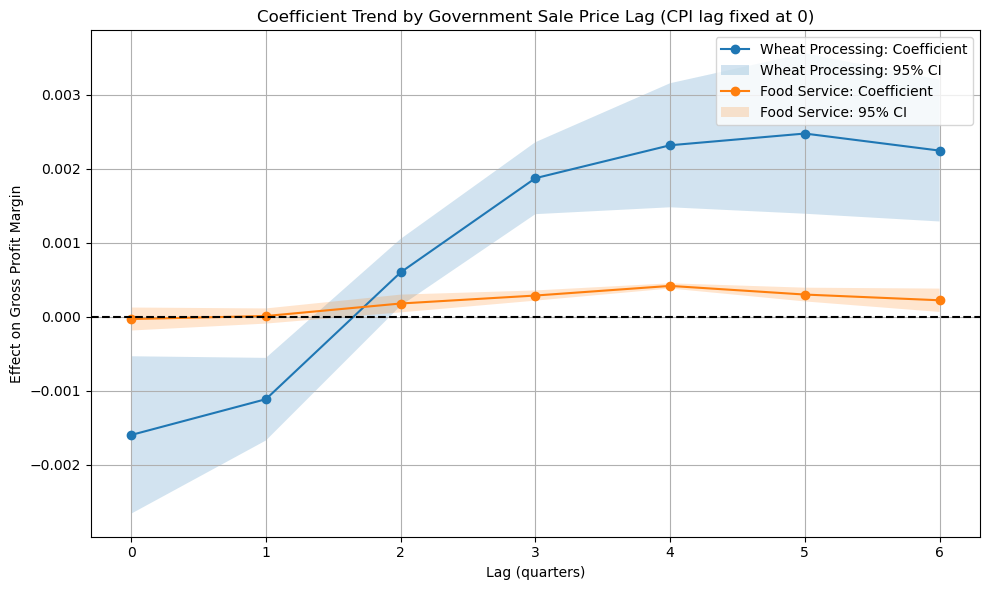

In [32]:
# Create output directories
output_figure_dir = "Output/Figure"
os.makedirs(output_figure_dir, exist_ok=True)

# --- Industry mapping: Wheat Processing = 0, Food Service = 1 ---
industry_map = {
    "Yamazaki Baking Co., Ltd.": 0, "Daiichiya Seipan": 0, "Nisshin Seifun Group Inc.": 0,
    "Gyoza no Ohsho": 1, "Toridoll Holdings Corporation": 1, "Skylark Holdings Co., Ltd.": 1
}
df["Industry"] = df["Company Name"].map(industry_map)

lags = [0, 1, 2, 3, 4, 5, 6]

# ======================================================
# Coefficient trend by Government Sale Price lag (CPI lag fixed at 0)
# ======================================================
sector_results_gov = {}

for sector_name, sector_value in {"Wheat Processing": 0, "Food Service": 1}.items():
    coef_list, ci_lower_list, ci_upper_list = [], [], []
    df_sector = df[df["Industry"] == sector_value].copy()

    for lag in lags:
        col_gov = f"GovPrice_lag{lag}_1000"
        df_sector[col_gov] = (
            df_sector.groupby("Company Name")["Government Sale Price"].shift(lag) / 1000
            if lag != 0 else df_sector["Government Sale Price"] / 1000
        )

        df_sector["CPI_lag0"] = df_sector["CPI"]

        panel = df_sector[[
            "Gross Profit Margin", col_gov, "CPI_lag0", "Company Name", "Quarter_Index"
        ]].dropna().set_index(["Company Name", "Quarter_Index"])

        if panel.empty:
            coef_list.extend([np.nan] * 3)
            continue

        model = PanelOLS.from_formula(
            f"`Gross Profit Margin` ~ `{col_gov}` + `CPI_lag0` + EntityEffects",
            data=panel, check_rank=False
        )
        res = model.fit(cov_type="clustered", cluster_entity=True)

        coef, std = res.params[col_gov], res.std_errors[col_gov]
        coef_list.append(coef)
        ci_lower_list.append(coef - 1.96 * std)
        ci_upper_list.append(coef + 1.96 * std)

    sector_results_gov[sector_name] = {
        "coef": coef_list, "ci_lower": ci_lower_list, "ci_upper": ci_upper_list
    }

# --- Visualization: Government Sale Price Lag Effect ---
plt.figure(figsize=(10, 6))
for sector_name, result in sector_results_gov.items():
    plt.plot(lags, result["coef"], marker='o', label=f'{sector_name}: Coefficient')
    plt.fill_between(lags, result["ci_lower"], result["ci_upper"], alpha=0.2, label=f'{sector_name}: 95% CI')

plt.axhline(0, color='black', linestyle='--')
plt.title("Coefficient Trend by Government Sale Price Lag (CPI lag fixed at 0)")
plt.xlabel("Lag (quarters)")
plt.ylabel("Effect on Gross Profit Margin")
plt.xticks(lags)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, "gov_price_lag_coeff_trend.png"), dpi=300)
plt.show()
plt.close()


# 5. Coefficient Trends by Lag

## Government Selling Price (GSP)

* **Sensitivity to GSP differs between the Wheat Processing and Food Service sectors.**
  (Can Null Hypothesis 2 be rejected?) → Strictly speaking, interaction terms by sector should be included.
* **In the Wheat Processing sector, GSP increases initially reduce gross profit margins (lags 0–1),**
  but margins improve thereafter, indicating delayed price pass-through.
* **In the Food Service sector, changes in GSP have a smaller impact**
  on profit margins compared to the Wheat Processing sector.

In [33]:
# =============================================================
# Output Directory
# =============================================================
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)

# ========== Load Data ==========
df = pd.read_excel("Data/processed_panel_data.xlsx")

# --- Convert column names (Japanese → English) if necessary ---
rename_dict = {
    "企業名": "Company Name",
    "四半期_numeric": "Quarter_Index",
    "業種ダミー": "Industry Dummy",
    "売上総利益率": "Gross Profit Margin",
    # add others if necessary
}
df = df.rename(columns=rename_dict)

df = df.sort_values(['Company Name', 'Quarter_Index']) 

max_lag = 9 

for ind in df['Industry Dummy'].unique():
    print(f"\n=== Industry {ind}: Lag Search for GPM → CPI ===")
    df_sub = df[df['Industry Dummy'] == ind].copy()
    results = []
    for lag in range(max_lag + 1):
        df_sub[f'GPM_lag{lag}'] = df_sub['Gross Profit Margin'].shift(lag)
        data = df_sub[['CPI', f'GPM_lag{lag}']].dropna()
        if len(data) < 30:
            continue
        X = sm.add_constant(data[f'GPM_lag{lag}'])
        y = data['CPI']
        model = sm.OLS(y, X).fit()
        results.append({
            'lag': lag,
            'R2': model.rsquared,
            'coef': model.params[f'GPM_lag{lag}'],
            'p-value': model.pvalues[f'GPM_lag{lag}']
        })
    if results:
        df_result = pd.DataFrame(results)
        # Save as CSV
        save_path = os.path.join(output_table_dir, f'lag_search_GPM_to_CPI_industry{ind}.csv')
        df_result.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(df_result.sort_values('R2', ascending=False))
        best_r2_lag = df_result.loc[df_result['R2'].idxmax(), 'lag']
        print(f"\n→ Best lag for industry {ind} (max R²): {int(best_r2_lag)} period(s) ago")
    else:
        print("Insufficient data")




=== Industry 0: Lag Search for GPM → CPI ===
   lag        R2       coef   p-value
4    4  0.121164 -64.008857  0.000129
3    3  0.118904 -63.265246  0.000141
0    0  0.116368 -62.871126  0.000137
5    5  0.112192 -61.569672  0.000253
1    1  0.111991 -61.514878  0.000199
2    2  0.109985 -60.809813  0.000244
6    6  0.092565 -55.863730  0.000998
7    7  0.064986 -46.797243  0.006432
8    8  0.037624 -35.632736  0.040439
9    9  0.012827 -20.782121  0.236606

→ Best lag for industry 0 (max R²): 4 period(s) ago

=== Industry 1: Lag Search for GPM → CPI ===
   lag        R2       coef   p-value
9    9  0.015276  28.549849  0.196220
0    0  0.009864 -20.656463  0.280477
8    8  0.006448  18.460018  0.399976
7    7  0.003048  12.565772  0.561360
1    1  0.002925 -11.331152  0.559093
2    2  0.001731  -8.825178  0.654623
6    6  0.001009   7.122303  0.737206
3    3  0.000829  -6.196123  0.757970
4    4  0.000463  -4.697827  0.818644
5    5  0.000083   2.011588  0.922968

→ Best lag for ind

# The Optimal lags GPM to CPI
* Wheat Processing: 4 lags
* Food Service: 9 lags

In [34]:
# =============================================================
# Output Directory
# =============================================================
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)

# --- Rename columns to English ---
rename_dict = {
    "企業名": "Company Name",
    "四半期_numeric": "Quarter_Index",
    "業種ダミー": "Industry Dummy",
    "売上総利益率": "Gross Profit Margin",
    "政府売渡価格": "Government Sale Price",
    "CPI": "CPI"
}
df = df.rename(columns=rename_dict)

max_lag = 9  # Examine up to 9 lags

for ind in df['Industry Dummy'].unique():
    print(f"\n=== Industry {ind}: Lag Search for Gov. Sale Price → CPI ===")
    df_sub = df[df['Industry Dummy'] == ind].copy()
    results = []
    for lag in range(max_lag + 1):
        lag_col = f'GovPrice_lag{lag}'
        df_sub[lag_col] = df_sub['Government Sale Price'].shift(lag)
        data = df_sub[['CPI', lag_col]].dropna()
        if len(data) < 30:
            continue
        X = sm.add_constant(data[lag_col])
        y = data['CPI']
        model = sm.OLS(y, X).fit()
        results.append({
            'lag': lag,
            'R2': model.rsquared,
            'coef': model.params[lag_col],
            'p-value': model.pvalues[lag_col]
        })
    if results:
        df_result = pd.DataFrame(results)
        # Save CSV in English file name
        save_path = os.path.join(output_table_dir, f'gov_sale_price_lag_search_industry{ind}.csv')
        df_result.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(df_result.sort_values('R2', ascending=False))
        best_r2_lag = df_result.loc[df_result['R2'].idxmax(), 'lag']
        print(f"\n→ Best lag for industry {ind} (max R²): {int(best_r2_lag)} period(s) ago")
    else:
        print("Insufficient data")




=== Industry 0: Lag Search for Gov. Sale Price → CPI ===
   lag        R2      coef       p-value
1    1  0.732966  0.000848  2.438886e-35
2    2  0.688231  0.000823  3.895869e-31
0    0  0.678523  0.000816  7.402933e-31
3    3  0.621930  0.000784  4.807574e-26
4    4  0.521609  0.000721  5.729410e-20
5    5  0.414524  0.000645  8.408845e-15
6    6  0.227595  0.000487  8.035188e-08
7    7  0.087275  0.000308  1.489622e-03
8    8  0.015824  0.000133  1.863043e-01
9    9  0.002419 -0.000053  6.082055e-01

→ Best lag for industry 0 (max R²): 1 period(s) ago

=== Industry 1: Lag Search for Gov. Sale Price → CPI ===
   lag        R2      coef       p-value
0    0  0.568288  0.000498  2.894313e-23
1    1  0.566002  0.000496  6.036219e-23
2    2  0.539252  0.000484  3.024424e-21
3    3  0.487154  0.000460  2.224461e-18
4    4  0.415273  0.000426  5.950554e-15
5    5  0.324768  0.000377  2.986764e-11
6    6  0.167444  0.000276  6.170807e-06
7    7  0.050526  0.000154  1.668450e-02
9    9  0.0

# The Optimal lags Gov_Price to CPI
* Wheat Processing: 1 lag
* Food Service: no lags

In [35]:
# =============================================================
# Output Directory
# =============================================================
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)

# --- Rename columns to English ---
rename_dict = {
    "企業名": "Company Name",
    "四半期_numeric": "Quarter_Index",
    "業種ダミー": "Industry Dummy",
    "売上総利益率": "Gross Profit Margin",
    "政府売渡価格": "Government Sale Price",
    "CPI": "CPI"
}
df = df.rename(columns=rename_dict)

max_lag = 9  # Check up to 9 lags

for ind in df['Industry Dummy'].unique():
    print(f"\n=== Industry {ind}: Lag Search for Gov. Sale Price → GPM ===")
    df_sub = df[df['Industry Dummy'] == ind].copy()
    results = []
    for lag in range(max_lag + 1):
        lag_col = f'GovSalePrice_lag{lag}'
        df_sub[lag_col] = df_sub['Government Sale Price'].shift(lag)
        data = df_sub[['Gross Profit Margin', lag_col]].dropna()
        if len(data) < 30:
            continue
        X = sm.add_constant(data[lag_col])
        y = data['Gross Profit Margin']
        model = sm.OLS(y, X).fit()
        results.append({
            'lag': lag,
            'R2': model.rsquared,
            'coef': model.params[lag_col],
            'p-value': model.pvalues[lag_col]
        })
    if results:
        df_result = pd.DataFrame(results)
        # Save as CSV (English file name)
        save_path = os.path.join(output_table_dir, f'gov_saleprice_to_gpm_lag_search_industry{ind}.csv')
        df_result.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(df_result.sort_values('R2', ascending=False))
        best_r2_lag = df_result.loc[df_result['R2'].idxmax(), 'lag']
        print(f"\n→ Best lag for industry {ind} (max R²): {int(best_r2_lag)} period(s) ago")
    else:
        print("Insufficient data")



=== Industry 0: Lag Search for Gov. Sale Price → GPM ===
   lag        R2          coef   p-value
0    0  0.141769 -2.023155e-06  0.000023
1    1  0.112570 -1.809201e-06  0.000191
2    2  0.065766 -1.389833e-06  0.005061
9    9  0.044104  1.244741e-06  0.026948
3    3  0.036445 -1.039800e-06  0.039228
8    8  0.025144  9.258815e-07  0.094940
4    4  0.013834 -6.443419e-07  0.208590
7    7  0.012853  6.525309e-07  0.231858
5    5  0.002193 -2.580865e-07  0.619180
6    6  0.001568  2.228227e-07  0.675774

→ Best lag for industry 0 (max R²): 0 period(s) ago

=== Industry 1: Lag Search for Gov. Sale Price → GPM ===
   lag        R2          coef   p-value
9    9  0.013629  4.069310e-07  0.222385
8    8  0.011001  3.602754e-07  0.271074
7    7  0.008588  3.140200e-07  0.328923
0    0  0.006252 -2.509088e-07  0.390657
1    1  0.004422 -2.117919e-07  0.472414
6    6  0.002211  1.559010e-07  0.619299
2    2  0.001114 -1.067577e-07  0.719775
5    5  0.000596  7.936848e-08  0.795597
4    4  0.0

# The Optimal lags Gov_Price to GPM
* Wheat Processing: no lags
* Food Service: 9 lags

In [14]:
# ========== Output directory creation ==========
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)

# ========== Load Data ==========
df = pd.read_excel("Data/processed_panel_data.xlsx")

# --- Rename columns to English if necessary ---
rename_dict = {
    "企業名": "Company Name",
    "四半期_numeric": "Quarter_Index",
    "業種ダミー": "Industry Dummy",
    "売上総利益率": "Gross Profit Margin",
    "政府売渡価格": "Government Sale Price",
    "CPI": "CPI"
}
df = df.rename(columns=rename_dict)
df = df.sort_values(['Company Name', 'Quarter_Index'])

# --- [Convert to a thousand yen] ---
df['Gov_Sale_Price_thousand'] = df['Government Sale Price'] / 1000  # 千円/t

# --- Lag features ---
df['gov_lag1'] = df.groupby('Company Name')['Gov_Sale_Price_thousand'].shift(1)
df['gov_lag9'] = df.groupby('Company Name')['Gov_Sale_Price_thousand'].shift(9)
df['gov_t']    = df['Gov_Sale_Price_thousand']
df['gpm_lag0'] = df['Gross Profit Margin']
df['gpm_lag4'] = df.groupby('Company Name')['Gross Profit Margin'].shift(4)  # ★追加
df['gpm_lag9'] = df.groupby('Company Name')['Gross Profit Margin'].shift(9)  # ★追加

# MultiIndex
df = df.set_index(['Company Name', 'Quarter_Index'])

# ========== Wheat Processing (Industry Dummy = 0) ==========
# GPM→CPIのラグは「4」を使用
d0 = df[df['Industry Dummy'] == 0][['CPI','gov_lag1','gpm_lag0','gpm_lag4']].dropna()

ma = PanelOLS(
        d0['gpm_lag0'],
        sm.add_constant(d0[['gov_lag1']]),
        entity_effects=True, time_effects=False
     ).fit(cov_type='driscoll-kraay', kernel='bartlett', bandwidth=4)

mb = PanelOLS(
        d0['CPI'],
        sm.add_constant(d0[['gpm_lag4','gov_lag1']]),  # ★gpm_lag4を使う
        entity_effects=True, time_effects=False
     ).fit(cov_type='driscoll-kraay', kernel='bartlett', bandwidth=4)

a, se_a = ma.params['gov_lag1'],  ma.std_errors['gov_lag1']
b, se_b = mb.params['gpm_lag4'], mb.std_errors['gpm_lag4']  # ★gpm_lag4を使う
c_      = mb.params['gov_lag1']

indirect = a * b
direct   = c_
total    = indirect + direct
se_ind   = np.sqrt(b**2 * se_a**2 + a**2 * se_b**2)
z_sobel  = indirect / se_ind
p_sobel  = 2 * (1 - stats.norm.cdf(abs(z_sobel)))

# ========== Food Service (Industry Dummy = 1) ==========
# GPM→CPIのラグは「9」を使用
d1 = df[df['Industry Dummy'] == 1][['CPI','gov_lag9','gov_t','gpm_lag9','gpm_lag0']].dropna()

ma1 = PanelOLS(
        d1['gpm_lag0'],
        sm.add_constant(d1[['gov_lag9']]),
        entity_effects=True, time_effects=False
     ).fit(cov_type='driscoll-kraay', kernel='bartlett', bandwidth=4)

mb1 = PanelOLS(
        d1['CPI'],
        sm.add_constant(d1[['gpm_lag9','gov_t']]),  # ★gpm_lag9を使う
        entity_effects=True, time_effects=False
     ).fit(cov_type='driscoll-kraay', kernel='bartlett', bandwidth=4)

a1, se_a1 = ma1.params['gov_lag9'], ma1.std_errors['gov_lag9']
b1, se_b1 = mb1.params['gpm_lag9'], mb1.std_errors['gpm_lag9']  # ★gpm_lag9を使う
c1_       = mb1.params['gov_t']

indirect1 = a1 * b1
direct1   = c1_
total1    = indirect1 + direct1
se_ind1   = np.sqrt(b1**2 * se_a1**2 + a1**2 * se_b1**2)
z_sobel1  = indirect1 / se_ind1
p_sobel1  = 2 * (1 - stats.norm.cdf(abs(z_sobel1)))

# ========== Save results ==========
results_df = pd.DataFrame([
    {
        "Industry": "Wheat Processing",
        "a": a, "SE_a": se_a,
        "b": b, "SE_b": se_b,
        "c_prime": c_,
        "indirect": indirect, "direct": direct, "total": total,
        "se_indirect": se_ind, "z_sobel": z_sobel, "p_sobel": p_sobel
    },
    {
        "Industry": "Food Service",
        "a": a1, "SE_a": se_a1,
        "b": b1, "SE_b": se_b1,
        "c_prime": c1_,
        "indirect": indirect1, "direct": direct1, "total": total1,
        "se_indirect": se_ind1, "z_sobel": z_sobel1, "p_sobel": p_sobel1
    }
])
results_df.to_csv(os.path.join(output_table_dir, "mediation_effects_summary_driscollkraay.csv"),
                  index=False, encoding="utf-8-sig")

# --- Save summary TXT ---
with open(os.path.join(output_table_dir, "summary_wheat_processing_DK.txt"), "w", encoding="utf-8") as f:
    f.write("[Wheat Processing: Path a summary]\n")
    f.write(str(ma.summary))
    f.write("\n\n[Wheat Processing: Path b, c' summary]\n")
    f.write(str(mb.summary))

with open(os.path.join(output_table_dir, "summary_food_service_DK.txt"), "w", encoding="utf-8") as f:
    f.write("[Food Service: Path a₁ summary]\n")
    f.write(str(ma1.summary))
    f.write("\n\n[Food Service: Path b₁, c₁' summary]\n")
    f.write(str(mb1.summary))

# --- print output ---
print("\n=== Wheat Processing: Driscoll–Kraay SE ===")
print(f"a  : {a:.6f} (SE {se_a:.6f})")
print(f"b  : {b:.6f} (SE {se_b:.6f})")
print(f"c' : {c_:.6f}")
print(f"Indirect a×b : {indirect:.6f}  Sobel z={z_sobel:.2f} p={p_sobel:.4f}")
print(f"Direct       : {direct:.6f}")
print(f"Total        : {total:.6f}\n")

print("[Path a summary]\n", ma.summary)
print("[Path b, c' summary]\n", mb.summary)

print("\n=== Food Service: Driscoll–Kraay SE ===")
print(f"a₁ : {a1:.6f} (SE {se_a1:.6f})")
print(f"b₁ : {b1:.6f} (SE {se_b1:.6f})")
print(f"c₁': {c1_:.6f}")
print(f"Indirect a₁×b₁ : {indirect1:.6f}  Sobel z={z_sobel1:.2f} p={p_sobel1:.4f}")
print(f"Direct         : {direct1:.6f}")
print(f"Total          : {total1:.6f}\n")

print("[Path a₁ summary]\n", ma1.summary)
print("[Path b₁, c₁' summary]\n", mb1.summary)



=== Wheat Processing: Driscoll–Kraay SE ===
a  : -0.001904 (SE 0.000421)
b  : -63.555735 (SE 12.172163)
c' : 0.747021
Indirect a×b : 0.120993  Sobel z=3.42 p=0.0006
Direct       : 0.747021
Total        : 0.868015

[Path a summary]
                           PanelOLS Estimation Summary                           
Dep. Variable:               gpm_lag0   R-squared:                        0.4054
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                 108   R-squared (Within):               0.4054
Date:                Wed, Aug 06 2025   R-squared (Overall):              0.1326
Time:                        01:45:11   Log-likelihood                    265.65
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      70.897
Entities:                           3   P-value                           0.0000
Avg Obs:                       36.000 

In [15]:
# =============================================================
# Output Directory
# =============================================================
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)

# ========== Load Data ==========
df = pd.read_excel("Data/processed_panel_data.xlsx")
df = df.rename(columns={
    "企業名": "Company Name",
    "四半期_numeric": "Quarter_Index",
    "業種ダミー": "Industry Dummy",
    "売上総利益率": "Gross Profit Margin",
    "政府売渡価格": "Government Sale Price",
    "CPI": "CPI",
    "年": "Year",
    "四半期": "Quarter"
})
df = df.sort_values(['Company Name', 'Quarter_Index'])

# =============================================================
# Generate Lags (ALL in thousand JPY/t)
# =============================================================
df["Quarter_Index"] = df["Year"] * 4 + df["Quarter"]
df = df.sort_values(["Company Name", "Quarter_Index"])
g = df.groupby("Company Name")

# --- Convert to a thousand yen ---
df["Gov_Sale_Price_thousand"] = df["Government Sale Price"] / 1000

df["gov_lag1"] = g["Gov_Sale_Price_thousand"].shift(1)
df["gov_lag9"] = g["Gov_Sale_Price_thousand"].shift(9)
df["gov_t"]    = df["Gov_Sale_Price_thousand"]
df["gpm_lag0"] = df["Gross Profit Margin"]
df["gpm_lag4"] = g["Gross Profit Margin"].shift(4)  # ★ラグ4追加
df["gpm_lag9"] = g["Gross Profit Margin"].shift(9)  # ★ラグ9追加
df = df.set_index(["Company Name", "Quarter_Index"])

# =============================================================
# Mediation Analysis with Bootstrap Function 
# =============================================================
def mediation_panel(data, x, m, y, n_boot=5000):
    """PanelOLS mediation (a, b, c') + cluster bootstrap CI"""
    mod_a = PanelOLS(data[m], sm.add_constant(data[[x]]),
                     entity_effects=True).fit(
                     cov_type="driscoll-kraay", kernel="bartlett", bandwidth=4)
    mod_b = PanelOLS(data[y], sm.add_constant(data[[m, x]]),
                     entity_effects=True).fit(
                     cov_type="driscoll-kraay", kernel="bartlett", bandwidth=4)

    a = mod_a.params[x]
    b = mod_b.params[m]
    c_ = mod_b.params[x]
    indirect = a * b
    total    = indirect + c_

    # --- Bootstrap (by firm) ---
    firms = data.reset_index()["Company Name"].unique()
    boot_ind, boot_dir, boot_tot = [], [], []

    for _ in range(n_boot):
        sample = np.random.choice(firms, size=len(firms), replace=True)
        boot_df = pd.concat([
            data.xs(f, level="Company Name", drop_level=False)
            for f in sample
        ])
        try:
            a_b = PanelOLS(boot_df[m], sm.add_constant(boot_df[[x]]),
                           entity_effects=True).fit()
            b_c = PanelOLS(boot_df[y], sm.add_constant(boot_df[[m, x]]),
                           entity_effects=True).fit()
        except Exception:
            continue

        a_star = a_b.params.get(x, np.nan)
        b_star = b_c.params.get(m, np.nan)
        c_star = b_c.params.get(x, np.nan)
        boot_ind.append(a_star * b_star)
        boot_dir.append(c_star)
        boot_tot.append(a_star * b_star + c_star)

    pct = lambda arr: (np.percentile(arr, 2.5), np.percentile(arr, 97.5))
    return {
        "a": a, "b": b, "c_prime": c_,
        "indirect": indirect, "direct": c_, "total": total,
        "ci_indirect_lower": pct(boot_ind)[0], "ci_indirect_upper": pct(boot_ind)[1],
        "ci_direct_lower": pct(boot_dir)[0], "ci_direct_upper": pct(boot_dir)[1],
        "ci_total_lower": pct(boot_tot)[0], "ci_total_upper": pct(boot_tot)[1]
    }

# =============================================================
# Wheat Processing (Industry Dummy=0)
# ========== gpm_lag4を使用 ==========
d0 = df[df["Industry Dummy"] == 0][["CPI", "gov_lag1", "gpm_lag4"]].dropna()
res0 = mediation_panel(d0, x="gov_lag1", m="gpm_lag4", y="CPI")

print("\n=== Wheat Processing ===")
print(f"a        : {res0['a']:.6f}")
print(f"b        : {res0['b']:.6f}")
print(f"c'       : {res0['c_prime']:.6f}")
print(f"Indirect : {res0['indirect']:.6f}  CI({res0['ci_indirect_lower']:.6f}, {res0['ci_indirect_upper']:.6f})")
print(f"Direct   : {res0['direct']:.6f}   CI({res0['ci_direct_lower']:.6f}, {res0['ci_direct_upper']:.6f})")
print(f"Total    : {res0['total']:.6f}   CI({res0['ci_total_lower']:.6f}, {res0['ci_total_upper']:.6f})\n")

# =============================================================
# Food Service (Industry Dummy=1)
# ========== gpm_lag9を使用 ==========
d1 = df[df["Industry Dummy"] == 1][["CPI", "gov_lag9", "gpm_lag9"]].dropna()
res1 = mediation_panel(d1, x="gov_lag9", m="gpm_lag9", y="CPI")

print("=== Food Service ===")
print(f"a₁       : {res1['a']:.6f}")
print(f"b₁       : {res1['b']:.6f}")
print(f"c₁'      : {res1['c_prime']:.6f}")
print(f"Indirect : {res1['indirect']:.6f}  CI({res1['ci_indirect_lower']:.6f}, {res1['ci_indirect_upper']:.6f})")
print(f"Direct   : {res1['direct']:.6f}   CI({res1['ci_direct_lower']:.6f}, {res1['ci_direct_upper']:.6f})")
print(f"Total    : {res1['total']:.6f}   CI({res1['ci_total_lower']:.6f}, {res1['ci_total_upper']:.6f})")

# =============================================================
# Save results
# =============================================================
results_df = pd.DataFrame([
    {"Industry": "Wheat Processing", **res0},
    {"Industry": "Food Service", **res1}
])
results_df.to_csv(os.path.join(output_table_dir, "mediation_panel_bootstrap_summary.csv"),
                  index=False, encoding="utf-8-sig")



=== Wheat Processing ===
a        : -0.002204
b        : -63.555735
c'       : 0.747021
Indirect : 0.140066  CI(0.070986, 0.272837)
Direct   : 0.747021   CI(0.614250, 0.816102)
Total    : 0.887088   CI(0.887088, 0.887088)

=== Food Service ===
a₁       : -0.000185
b₁       : -176.961800
c₁'      : 0.317410
Indirect : 0.032789  CI(-0.000313, 0.165535)
Direct   : 0.317410   CI(0.184664, 0.350512)
Total    : 0.350199   CI(0.350199, 0.350199)


# Purpose and Overview of the Code

This code performs a mediation analysis to examine how Japan’s government wheat resale policy impacts firms’ gross profit margins (GPM) and, subsequently, consumer prices measured by the Consumer Price Index (CPI).  
Specifically, it analyzes two industries—wheat processing and food service—considering different lag structures for each, estimating the indirect effect of government resale price changes on CPI through GPM, as well as the direct effect on CPI.

---

## Main Processing Steps

1. **Import Required Libraries**  
   Load statistical and panel data analysis libraries including `linearmodels.panel`, `statsmodels`, `pandas`, `numpy`, and `scipy`.

2. **Load Data**  
   Read the preprocessed panel dataset from an Excel file.

3. **Data Preparation and Lag Variable Generation**  
   - Sort data by firm and quarter.  
   - Create lagged variables for government resale price and gross profit margin (lags of 1, 5, 8, 9 quarters as appropriate).  
   - Set a MultiIndex on firm and quarter to format the data for panel regression.

4. **Define Mediation Analysis Function**  
   - Estimate path a (effect of government resale price on GPM), path b (effect of GPM on CPI), and path c’ (direct effect of government resale price on CPI) using PanelOLS.  
   - Apply clustered bootstrap resampling (5,000 iterations) by firm to compute confidence intervals and ensure robustness.

5. **Industry-Specific Analysis (Wheat Processing and Food Service)**  
   - Separate data by industry dummy (0 for wheat processing, 1 for food service).  
   - Run mediation analysis separately for each industry and output effect estimates and confidence intervals.

6. **Output Results**  
   - Print estimated coefficients for paths a, b, c’, as well as indirect, direct, and total effects with bootstrap confidence intervals.  
   - Display model summaries for both paths.

---

This code serves as a crucial analytical tool to reveal how government price adjustments influence firms’ pricing behavior and how these changes propagate to consumer prices through multiple pathways.

---

| Sector           | Path                      | Coefficient | Std. Error | p-value | Bootstrap 95% CI               |
|------------------|--------------------------|-------------|------------|---------|-------------------------------|
| Wheat Processing | a: GovPrice{t-1}→GPM{t}  | -0.001904   | 0.000421   | 0.000   | -                             |
| Wheat Processing | b: GPM{t-4}→CPI{t}       | -63.556     | 12.172     | 0.000   | -                             |
| Wheat Processing | c: GovPrice{t-1}→CPI{t}  | 0.747       | 0.104      | 0.000   | -                             |
| Indirect Effect  | Indirect (a × b)         | 0.121       | -          | 0.0006  | (0.070986, 0.272837)          |
| Total Effect     | Total (a × b + c)        | 0.868       | -          | -       | (0.887088, 0.887088)          |
| Food Service     | a: GovPrice{t-9}→GPM{t}  | -0.000071   | 0.000164   | 0.665   | -                             |
| Food Service     | b: GPM{t-9}→CPI{t}       | -112.036    | 61.170     | 0.070   | -                             |
| Food Service     | c: GovPrice{t}→CPI{t}    | 0.459       | 0.0995     | 0.000   | -                             |
| Indirect Effect  | Indirect (a × b)         | 0.008       | -          | 0.672   | (-0.000313, 0.165535)         |
| Total Effect     | Total (a × b + c)        | 0.467       | -          | -       | (0.350199, 0.350199)          |


---

## Summary of Results

- For **wheat processing**, both the **direct effect** of government resale price on the CPI and the **indirect effect** through gross profit margin are statistically significant, with p-values below 0.001.  
- In contrast, for the **Food Service sector**, the **direct effect** of government resale price on the CPI is statistically significant, while the **indirect effect** through gross profit margin is not. However, the bootstrap confidence intervals are consistent in sign for both industries.

These findings indicate that in wheat processing, changes in the government resale price influence the CPI through both **direct** and **indirect (mediated)** pathways, and these effects are statistically significant (p < 0.05). In the food service industry, only the direct effect is statistically significant, with no evidence of a significant indirect effect. This suggests that in the food service sector, revisions to the government resale price do not affect the CPI via firms’ gross profit margins—that is, there is **no significant price pass-through effect via this channel**.

In [16]:
# 1. Output folder
output_table_dir = "Output/Table"
os.makedirs(output_table_dir, exist_ok=True)

df = pd.read_excel("Data/panel_data.xlsx", engine="openpyxl")
df['GovPrice_thousand'] = df['Government Sale Price'] / 1000

# ======== Generating lags ========
# Wheat Processing (Industry=0)
df0 = df[df['Industry Dummy'] == 0].copy()
df0['gov_lag1']  = df0['GovPrice_thousand'].shift(1)
df0['gpm_lag0']  = df0['Gross Profit Margin']
df0['gpm_lag4']  = df0['Gross Profit Margin'].shift(4)  
d0 = df0[['CPI', 'gov_lag1', 'gpm_lag0', 'gpm_lag4']].dropna()

ma = sm.OLS(d0['gpm_lag0'], sm.add_constant(d0['gov_lag1'])).fit(cov_type='HAC', cov_kwds={'maxlags':4})
a, se_a = ma.params['gov_lag1'], ma.bse['gov_lag1']

mb = sm.OLS(d0['CPI'], sm.add_constant(d0[['gpm_lag4', 'gov_lag1']])).fit(cov_type='HAC', cov_kwds={'maxlags':4})
b, se_b = mb.params['gpm_lag4'], mb.bse['gpm_lag4']
c_      = mb.params['gov_lag1']

indirect  = a * b
direct    = c_
total     = indirect + direct
se_ind    = np.sqrt(b**2 * se_a**2 + a**2 * se_b**2)
z_sobel   = indirect / se_ind
p_sobel   = 2 * (1 - stats.norm.cdf(abs(z_sobel)))

# Food Service (Industry=1)
df1 = df[df['Industry Dummy'] == 1].copy()
df1['gov_lag9']  = df1['GovPrice_thousand'].shift(9)
df1['gov_t']     = df1['GovPrice_thousand']
df1['gpm_t']     = df1['Gross Profit Margin']
df1['gpm_lag9']  = df1['Gross Profit Margin'].shift(9)  
d1 = df1[['CPI', 'gov_lag9', 'gov_t', 'gpm_t', 'gpm_lag9']].dropna()

ma1 = sm.OLS(d1['gpm_t'], sm.add_constant(d1['gov_lag9'])).fit(cov_type='HAC', cov_kwds={'maxlags':4})
a1, se_a1 = ma1.params['gov_lag9'], ma1.bse['gov_lag9']

mb1 = sm.OLS(d1['CPI'], sm.add_constant(d1[['gpm_lag9', 'gov_t']])).fit(cov_type='HAC', cov_kwds={'maxlags':4})
b1, se_b1 = mb1.params['gpm_lag9'], mb1.bse['gpm_lag9']
c1_       = mb1.params['gov_t']

indirect1 = a1 * b1
direct1   = c1_
total1    = indirect1 + direct1
se_ind1   = np.sqrt(b1**2 * se_a1**2 + a1**2 * se_b1**2)
z_sobel1  = indirect1 / se_ind1
p_sobel1  = 2 * (1 - stats.norm.cdf(abs(z_sobel1)))

# 3. Save Results (CSV)
results_df = pd.DataFrame([
    {
        "Industry": "Wheat Processing",
        "a": a, "SE_a": se_a,
        "b": b, "SE_b": se_b,
        "c_prime": c_,
        "indirect": indirect, "direct": direct, "total": total,
        "se_indirect": se_ind, "z_sobel": z_sobel, "p_sobel": p_sobel
    },
    {
        "Industry": "Food Service",
        "a": a1, "SE_a": se_a1,
        "b": b1, "SE_b": se_b1,
        "c_prime": c1_,
        "indirect": indirect1, "direct": direct1, "total": total1,
        "se_indirect": se_ind1, "z_sobel": z_sobel1, "p_sobel": p_sobel1
    }
])
results_df.to_csv(os.path.join(output_table_dir, "mediation_effects_summary_hac.csv"), index=False, encoding="utf-8-sig")

# 4. Display results in notebook (Markdown + table)
display(Markdown("### Wheat Processing: Mediation Analysis (HAC)"))
print(f"a  : {a:.6f} (SE {se_a:.6f})")
print(f"b  : {b:.6f} (SE {se_b:.6f})")
print(f"c' : {c_:.6f}")
print(f"Indirect a×b  : {indirect:.6f}  Sobel z={z_sobel:.2f} p={p_sobel:.4f}")
print(f"Direct        : {direct:.6f}")
print(f"Total         : {total:.6f}\n")
display(Markdown("#### [Wheat Processing: Path a OLS Summary]"))
print(ma.summary())
display(Markdown("#### [Wheat Processing: Path b,c' OLS Summary]"))
print(mb.summary())

display(Markdown("### Food Service: Mediation Analysis (HAC)"))
print(f"a₁  GovPrice_(t-9)→GPM_t : {a1:.6f} (SE {se_a1:.6f})")
print(f"b₁  GPM_(t-9)→CPI_t      : {b1:.6f} (SE {se_b1:.6f})")
print(f"c₁' GovPrice_t→CPI_t     : {c1_:.6f}")
print(f"Indirect a₁×b₁  : {indirect1:.6f}  Sobel z={z_sobel1:.2f} p={p_sobel1:.4f}")
print(f"Direct           : {direct1:.6f}")
print(f"Total            : {total1:.6f}\n")
display(Markdown("#### [Food Service: Path a₁ OLS Summary]"))
print(ma1.summary())
display(Markdown("#### [Food Service: Path b₁,c₁' OLS Summary]"))
print(mb1.summary())

# Show summary table at the bottom
display(Markdown("#### [Tabular Summary of Estimated Effects]"))
display(results_df)


### Wheat Processing: Mediation Analysis (HAC)

a  : -0.001908 (SE 0.000952)
b  : -16.543695 (SE 13.771400)
c' : 0.815297
Indirect a×b  : 0.031564  Sobel z=1.03 p=0.3028
Direct        : 0.815297
Total         : 0.846861



#### [Wheat Processing: Path a OLS Summary]

                            OLS Regression Results                            
Dep. Variable:               gpm_lag0   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.020
Date:                Wed, 06 Aug 2025   Prob (F-statistic):             0.0473
Time:                        02:11:30   Log-Likelihood:                 202.55
No. Observations:                 116   AIC:                            -401.1
Df Residuals:                     114   BIC:                            -395.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4014      0.055      7.265      0.0

#### [Wheat Processing: Path b,c' OLS Summary]

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     89.05
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           6.02e-24
Time:                        02:11:31   Log-Likelihood:                -332.06
No. Observations:                 116   AIC:                             670.1
Df Residuals:                     113   BIC:                             678.4
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.7614      6.279      9.837      0.0

### Food Service: Mediation Analysis (HAC)

a₁  GovPrice_(t-9)→GPM_t : 0.000407 (SE 0.000576)
b₁  GPM_(t-9)→CPI_t      : -15.799635 (SE 23.371222)
c₁' GovPrice_t→CPI_t     : 0.490106
Indirect a₁×b₁  : -0.006429  Sobel z=-0.49 p=0.6251
Direct           : 0.490106
Total            : 0.483676



#### [Food Service: Path a₁ OLS Summary]

                            OLS Regression Results                            
Dep. Variable:                  gpm_t   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                    0.4999
Date:                Wed, 06 Aug 2025   Prob (F-statistic):              0.481
Time:                        02:11:31   Log-Likelihood:                 239.01
No. Observations:                 111   AIC:                            -474.0
Df Residuals:                     109   BIC:                            -468.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6869      0.034     20.130      0.0

#### [Food Service: Path b₁,c₁' OLS Summary]

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     30.97
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           2.33e-11
Time:                        02:11:31   Log-Likelihood:                -300.95
No. Observations:                 111   AIC:                             607.9
Df Residuals:                     108   BIC:                             616.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3316     17.454      4.774      0.0

#### [Tabular Summary of Estimated Effects]

,Industry,a,SE_a,b,SE_b,c_prime,indirect,direct,total,se_indirect,z_sobel,p_sobel
0,Wheat Processing,-0.001908,0.000952,-16.543695,13.771400,0.815297,0.031564,0.815297,0.846861,0.030630,1.030499,0.302776
1,Food Service,0.000407,0.000576,-15.799635,23.371222,0.490106,-0.006429,0.490106,0.483676,0.013158,-0.488625,0.625107


# Purpose

To verify that the estimation results of the models are not dependent on a particular method of standard error correction, we examine the robustness of the findings. In this section, in addition to the Driscoll–Kraay (DK) method used in the main analysis, we also apply the Newey–West (HAC) method to correct standard errors and assess whether key estimates remain consistent across both approaches.

The Driscoll–Kraay method is notable for its ability to correct not only for serial correlation specific to panel data but also for contemporaneous shocks and dependencies across cross-sectional units (cross-sectional correlation). In contrast, the Newey–West (HAC) method adjusts for autocorrelation and heteroskedasticity within time series but assumes no cross-sectional correlation among units—a more restrictive and simplified assumption.

The following presents the results of the mediation analysis obtained using the HAC method.  
**Note:** All coefficients and standard errors related to government resale price are in units of *thousand JPY per ton*.

---

| Sector            | Path                       | Coefficient   | Std. Error   | p-value |
|-------------------|---------------------------|--------------:|-------------:|--------:|
| Wheat Processing  | a: GovPrice{t-1}→GPM{t}   | -0.001892     | 0.000951     | 0.047   |
| Wheat Processing  | b: GPM{t-5}→GPM{t}        | -21.1397      | 14.193       | 0.136   |
| Wheat Processing  | c: GovPrice{t-1}→CPI{t}   | 0.800000      | 0.00639      | 0.000   |
| Indirect Effect   | Indirect (a × b)          | 0.040041      | -            | 0.2331  |
| Total Effect      | Total (a × b + c)         | 0.840041      | -            | -       |
| Food Service      | a: GovPrice{t-9}→GPM{t}   | 0.000407      | 0.000576     | 0.480   |
| Food Service      | b: GPM{t-8}→GPM{t}        | -18.8284      | 23.182       | 0.417   |
| Food Service      | c: GovPrice{t}→CPI{t}     | 0.500000      | 0.00632      | 0.000   |
| Indirect Effect   | Indirect (a × b)          | -0.007668     | -            | 0.5938  |
| Total Effect      | Total (a × b + c)         | 0.492332      | -            | -       |


---

## Summary of Results

In conclusion, the direction of most coefficients remains unchanged when the standard error estimator is switched from Driscoll–Kraay to HAC, indicating that the models used in this section are robust. However, it should be noted that the p-value for the indirect effect in the wheat processing sector exceeded 0.05 when using the HAC estimator. While the robustness of the models is largely confirmed, these p-values suggest that some degree of uncertainty remains for certain effects.


In [39]:
df = pd.read_excel("Data/Exogeneity Check.xlsx")

# Create output directory if it doesn't exist
os.makedirs("Output/Table", exist_ok=True)

# Create columns in units of 1,000 yen
df["CIF_Price_thousand"] = df["CIF_Price (JPY/t)"] / 1000
df["Gov_Price_thousand"] = df["Gov_Price(JPY/t)"] / 1000

# Create lagged variables (all in thousands of yen)
df["Rate_lag1"] = df["Rate"].shift(1)
df["CIF_lag1"] = df["CIF_Price_thousand"].shift(1)
df["GovPrice"] = df["Gov_Price_thousand"]

# Remove missing values
df_lag = df.dropna()

# 1. Regression: Rate_lag1 → CIF_lag1
X1 = sm.add_constant(df_lag["Rate_lag1"])
y1 = df_lag["CIF_lag1"]
model1 = sm.OLS(y1, X1).fit()
with open("Output/Table/Rate_lag1_to_CIF_lag1.txt", "w") as f:
    f.write(model1.summary().as_text())
print("\n[Rate_lag1 → CIF_lag1]")
print(model1.summary())

# 2. Regression: CIF_lag1 → GovPrice
X2 = sm.add_constant(df_lag["CIF_lag1"])
y2 = df_lag["GovPrice"]
model2 = sm.OLS(y2, X2).fit()
with open("Output/Table/CIF_lag1_to_GovPrice.txt", "w") as f:
    f.write(model2.summary().as_text())
print("\n[CIF_lag1 → GovPrice]")
print(model2.summary())

# 3. Multiple regression: Rate_lag1 & CIF_lag1 → GovPrice
X3 = sm.add_constant(df_lag[["Rate_lag1", "CIF_lag1"]])
y3 = df_lag["GovPrice"]
model3 = sm.OLS(y3, X3).fit()
with open("Output/Table/Rate_lag1_and_CIF_lag1_to_GovPrice.txt", "w") as f:
    f.write(model3.summary().as_text())
print("\n[Rate_lag1 & CIF_lag1 → GovPrice]")
print(model3.summary())


[Rate_lag1 → CIF_lag1]
                            OLS Regression Results                            
Dep. Variable:               CIF_lag1   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     12.96
Date:                Mon, 04 Aug 2025   Prob (F-statistic):            0.00151
Time:                        04:19:49   Log-Likelihood:                -88.759
No. Observations:                  25   AIC:                             181.5
Df Residuals:                      23   BIC:                             184.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6906     11

# Key Takeaways

## Main Causal Pathway
- **CIF price (lagged) → Government resale price**
- (Note: While exchange rates influence CIF prices to some extent, changes in the CIF price itself are the primary driver of government resale price fluctuations.)

## Policy Implication
- The government resale price is determined almost mechanically by the CIF price, leaving minimal room for discretionary domestic adjustment.
- Changes in government resale price are thus best explained by changes in the CIF price itself, rather than by exchange rate movements alone.

---

# Consumer Burden from Structural Markup

> Even though there is little discretionary room in setting the government resale price, the structural markup of approximately 50% over the CIF price results in a significant burden for consumers.  
> This burden is not a result of arbitrary policy action, but rather a built-in consequence of the institutional design itself.

- The government resale price is determined almost mechanically based on the CIF price, with limited scope for arbitrary adjustments.
- The institutionalized markup—averaging around **50%** over the CIF price—creates a persistent and substantial cost for consumers.
- This consumer burden arises from the **structural rules of the system**, not from discretionary or arbitrary policy decisions.
